In [ ]:
#표준데이터 불러오기
import pandas as pd

file_path = r"C:\\공모전\\2025천안\\전국대학및전문대학정보표준데이터.csv"

df = pd.read_csv(file_path, encoding="euc-kr")

pd.DataFrame(df).head(5)

,학교명,학교 영문명,본분교구분명,대학구분명,학교구분명,설립형태구분명,시도코드,시도명,소재지도로명주소,소재지지번주소,도로명우편번호,소재지우편번호,홈페이지주소,대표전화번호,대표팩스번호,설립일자,기준연도,데이터기준일자,제공기관코드,제공기관명
0,강남대학교 융복합대학원,Kangnam Graduate School Of Convergence,본교,대학원,특수대학원,사립,41,경기도,"경기도 용인시 기흥구 강남로 40 (구갈동, 강남대학교)",NaN,16979,NaN,grd.kangnam.ac.kr,031-280-3500,031-280-3479,2018-03-01,2024,2025-01-08,B340014,한국대학교육협의회
1,강서대학교 교육대학원,"The Graduate School Of Education, GANGSEO UNIV...",본교,대학원,특수대학원,사립,11,서울특별시,"서울특별시 강서구 까치산로24길 47 (화곡동, 케이씨대학교)",NaN,7661,NaN,graduate.gangseo.ac.kr,02-2600-2441,02-2600-2449,2002-10-30,2024,2025-01-08,B340014,한국대학교육협의회
2,강서대학교 사회복지대학원,"The Graduate School Of Social Welfare, GANGSEO...",본교,대학원,특수대학원,사립,11,서울특별시,"서울특별시 강서구 까치산로24길 47 (화곡동, 케이씨대학교)",NaN,7661,NaN,graduate.gangseo.ac.kr/,02-2600-2441,02-2600-2449,2002-10-30,2024,2025-01-08,B340014,한국대학교육협의회
3,강서대학교 신학대학원,"The Graduate School Of Theology, GANGSEO UNIVE...",본교,대학원,특수대학원,사립,11,서울특별시,"서울특별시 강서구 까치산로24길 47 (화곡동, 케이씨대학교)",NaN,7661,NaN,graduate.gangseo.ac.kr/,02-2600-2441,02-2600-2449,1994-10-21,2024,2025-01-08,B340014,한국대학교육협의회
4,강서대학교 일반대학원,The Graduate School Of GANGSEO UNIVERSITY,본교,대학원,일반대학원,사립,11,서울특별시,"서울특별시 강서구 까치산로24길 47 (화곡동, 케이씨대학교)",NaN,7661,NaN,graduate.gangseo.ac.kr/,02-2600-2441,02-2600-2449,2002-10-30,2024,2025-01-08,B340014,한국대학교육협의회


In [8]:
# 제외할 조건 정의
exclude_regions = ["서울특별시", "경기도", "인천광역시"]
exclude_regions2 = ["경기도 의왕시 철도박물관로 157 (월암동, 한국교통대학교)"]

# 조건 적용 (둘 다 제외)
df_filtered = df[
    (~df["시도명"].isin(exclude_regions)) &
    (~df["소재지도로명주소"].isin(exclude_regions2))
]

# 결과 저장
output_path = "filtered_university_data.csv"
df_filtered.to_csv(output_path, index=False, encoding="cp949")

print("필터링 완료! 결과는 CSV로 저장되었습니다.")

필터링 완료! 결과는 CSV로 저장되었습니다.


In [ ]:
#CSV의 도로명주소를 정리해 ‘광역시도/시군구’를 추출

import pandas as pd
import re
import numpy as np

# 1. CSV 불러오기 (파일 경로 수정 필요)
file_path = r"C:\공모전\2025천안\0817 내용\filtered_university_data.csv"
df = pd.read_csv(file_path, encoding="cp949")

# 2. 주소 전처리 함수 (괄호 제거, 공백 정리)
def clean_addr(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    s = re.sub(r"\([^)]*\)", " ", s)   # 괄호 안 텍스트 제거
    s = re.sub(r"\s+", " ", s)         # 다중 공백 하나로
    return s.strip()

# 3. 행정구역 파싱 함수
def parse_korean_address(addr):
    if not isinstance(addr, str) or not addr.strip():
        return {"광역시도": np.nan, "시군구": np.nan}

    # 광역시/도 추출
    m = re.match(r"^([^ ]+(특별시|광역시|특별자치시|특별자치도|도))", addr)
    sido = m.group(1) if m else np.nan
    rest = addr[m.end():].strip() if m else addr

    # 시/군/구 추출 (첫 번째로 나오는 것)
    m2 = re.match(r"^([^ ]+(시|군|구))", rest)
    sigungu = m2.group(1) if m2 else np.nan

    return {"광역시도": sido, "시군구": sigungu}

# 4. 주소 정리 + 파싱 적용
df["주소_clean"] = df["소재지도로명주소"].map(clean_addr)
parsed = df["주소_clean"].map(parse_korean_address).apply(pd.Series)
df = pd.concat([df, parsed], axis=1)

# 5. 그룹핑 및 카운트
# (광역시도, 시군구) 기준 묶기
counts = (
    df.groupby(["광역시도", "시군구"])
    .size()
    .reset_index(name="count")
    .sort_values(["광역시도", "count"], ascending=[True, False])
)

# (광역시도 단위)만 묶기
counts_sido = (
    df.groupby("광역시도")
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)

# 6. 결과 저장
counts.to_csv("counts_by_sido_sigungu.csv", index=False, encoding="cp949")
counts_sido.to_csv("counts_by_sido.csv", index=False, encoding="cp949")

print("✅ 집계 완료! 'counts_by_sido_sigungu.csv'와 'counts_by_sido.csv'로 저장되었습니다.")


✅ 집계 완료! 'counts_by_sido_sigungu.csv'와 'counts_by_sido.csv'로 저장되었습니다.


In [ ]:
#우편번호 카운트

import pandas as pd

# 1. CSV 불러오기
file_path = r"C:\공모전\2025천안\0817 내용\filtered_university_data.csv"  # 본인 파일 경로로 수정
df = pd.read_csv(file_path, encoding="cp949")

# 2. 우편번호 기준으로 묶어서 개수 카운트
# (우편번호 열 이름이 실제 CSV와 맞는지 확인 필요)
zipcode_counts = df["도로명우편번호"].value_counts()

# 3. 출력
print("=== 우편번호별 개수 ===")
print(zipcode_counts)

=== 우편번호별 개수 ===
도로명우편번호
54896    17
34134    16
54538    15
61186    14
31460    14
         ..
39913     1
58607     1
55313     1
47583     1
25247     1
Name: count, Length: 278, dtype: int64


In [ ]:
#우편번호 중복제거

import pandas as pd

# 1. CSV 불러오기
file_path = r"C:\공모전\2025천안\0817 내용\filtered_university_data.csv"
df = pd.read_csv(file_path, encoding="cp949")

# 2. 우편번호 기준으로 중복 제거 (처음 등장한 행만 남김)
df_unique_zip = df.drop_duplicates(subset="도로명우편번호")

# 3. CSV로 저장
save_path = r"C:\공모전\2025천안\\unique_zipcodes.csv"
df_unique_zip.to_csv(save_path, index=False, encoding="cp949")

print(f"중복 제거된 우편번호 데이터가 저장되었습니다: {save_path}")

중복 제거된 우편번호 데이터가 저장되었습니다: C:\공모전\2025천안\\unique_zipcodes.csv


In [ ]:
#지역별 대하개수 카운트
import pandas as pd

# 1. CSV 불러오기
file_path = r"C:\공모전\2025천안\unique_zipcodes.csv"
df = pd.read_csv(file_path, encoding="cp949")

# 2. 주소에서 카운트할 '지역' 추출 함수
def extract_count_region(address):
    # 공백으로 분리
    parts = address.split()
    # 광역시/특별자치도
    if parts[0].endswith(("광역시", "특별자치도", "특별자치시")):
        return parts[0]
    # 도 단위
    elif parts[0].endswith("도"):
        # 도 뒤에 오는 시/군 이름
        if len(parts) > 1:
            return parts[1]
        else:
            return parts[0]  # 시/군이 없으면 도 이름
    else:
        return parts[0]  # 예외 처리

# 3. 새로운 컬럼 생성
df["카운트지역"] = df["소재지도로명주소"].apply(extract_count_region)

# 4. 지역별 카운트
region_counts = df["카운트지역"].value_counts()

# 5. 출력
print("=== 카운트 지역별 개수 ===")
print(region_counts)

# 6. CSV로 저장
df.to_csv(r"C:\공모전\2025천안\counted_region.csv", index=False, encoding="utf-8-sig")

=== 카운트 지역별 개수 ===
카운트지역
부산광역시      30
강원특별자치도    26
전북특별자치도    20
대전광역시      19
광주광역시      17
대구광역시      16
경산시        11
천안시        11
청주시         9
진주시         7
창원시         6
울산광역시       6
세종특별자치시     5
아산시         5
제주특별자치도     5
무안군         4
경주시         4
나주시         4
포항시         4
구미시         4
김해시         4
논산시         3
목포시         3
양산시         3
제천시         3
영주시         3
안동시         3
순천시         3
영암군         2
김천시         2
칠곡군         2
충주시         2
여수시         2
거창군         2
영천시         2
공주시         2
음성군         2
부여군         1
서산시         1
영동군         1
거제시         1
영광군         1
상주시         1
괴산군         1
예산군         1
금산군         1
문경시         1
광양시         1
예천군         1
남해군         1
보령시         1
당진시         1
옥천군         1
청양군         1
담양군         1
곡성군         1
사천시         1
홍성군         1
고령군         1
Name: count, dtype: int64


In [ ]:
#엑셀 파일들이 있는 폴더·패턴·시트·셀 범위를 지정하고, 집계 요약을 저장할 CSV 파일명을 정하는 CODE

from pathlib import Path

# ===== 사용자 설정 =====
DIR_PATH    = r"C:\공모전\2025천안\연령별 인구수"  # 처리할 폴더 경로
GLOB        = "*.xlsx"                              # 처리할 파일 패턴 (하위폴더 포함하려면 "**/*.xlsx")
SHEET_NAME  = None                                   # 특정 시트명("Sheet1") 또는 None=첫 시트
ADDRESSES   = [f"C{r}" for r in range(68, 114, 3)]   # C68, C71, ..., C113
OUT_CSV_NAME = "cell_sums_summary.csv"               # 결과 저장 파일명(위 폴더에 저장)
# =======================


In [ ]:
#천안 연령별 인구수

import csv
from openpyxl import load_workbook
import pandas as pd

def to_number(v):
    """숫자/문자열(쉼표포함) -> float. 변환 불가 시 None."""
    if v is None:
        return None
    if isinstance(v, (int, float)):
        return float(v)
    if isinstance(v, str):
        s = v.replace(",", "").strip()
        if s == "":
            return None
        try:
            return float(s)
        except ValueError:
            return None
    return None

def sum_cells_one_file(file_path: Path, sheet_name=None, addresses=None):
    """한 개 엑셀 파일에서 지정 셀들의 합과 상세값을 반환."""
    wb = load_workbook(file_path, data_only=True, read_only=True)
    ws = wb[sheet_name] if sheet_name else wb.active
    values = {}
    skipped = []
    for addr in addresses or []:
        raw = ws[addr].value
        num = to_number(raw)
        if num is None:
            skipped.append(addr)
        else:
            values[addr] = num
    total = sum(values.values())
    return total, values, skipped

# 실행
base = Path(DIR_PATH)
assert base.exists(), f"폴더가 없습니다: {base}"

files = sorted(base.glob(GLOB))
if not files:
    raise FileNotFoundError("처리할 파일이 없습니다. DIR_PATH 또는 GLOB 패턴을 확인하세요.")

rows = []
grand_total = 0.0
errors = []

for f in files:
    try:
        total, values, skipped = sum_cells_one_file(f, SHEET_NAME, ADDRESSES)
        grand_total += total
        row = {"filename": f.name, "sum": total, "skipped": ";".join(skipped)}
        for addr in ADDRESSES:
            row[addr] = values.get(addr, "")
        rows.append(row)
    except Exception as e:
        errors.append((f.name, str(e)))

# 표로 보기
df_summary = pd.DataFrame(rows, columns=["filename", "sum", "skipped"] + ADDRESSES)
display(df_summary)

print(f"\n전체 합계(모든 파일): {grand_total}")

# CSV 저장(엑셀 바로 열 수 있도록 UTF-8-SIG)
out_path = base / OUT_CSV_NAME
df_summary.to_csv(out_path, index=False, encoding="utf-8-sig")
print(f"요약 저장: {out_path}")

if errors:
    print("\n(참고) 오류 발생 파일 목록:")
    for name, msg in errors:
        print(f"  - {name}: {msg}")


,filename,sum,skipped,C68,C71,C74,C77,C80,C83,C86,C89,C92,C95,C98,C101,C104,C107,C110,C113
0,연령별인구현황(2020.7월).xlsx,153891.0,,8392.0,8814.0,8689.0,9168.0,9537.0,9491.0,9778.0,10025.0,10593.0,10505.0,9463.0,9673.0,9709.0,9982.0,9945.0,10127.0
1,연령별인구현황(2021.7월).xlsx,151177.0,,7228.0,8496.0,9005.0,8818.0,9223.0,9528.0,9578.0,9757.0,10057.0,10664.0,10510.0,9365.0,9590.0,9605.0,9897.0,9856.0
2,연령별인구현황(2022.07월).xlsx,149014.0,,6810.0,7407.0,8699.0,9189.0,8980.0,9180.0,9500.0,9781.0,9875.0,10112.0,10735.0,10529.0,9385.0,9512.0,9559.0,9761.0
3,연령별인구현황(2023.7월).xlsx,147416.0,,6852.0,7090.0,7673.0,9051.0,9467.0,9069.0,9176.0,9624.0,9903.0,9974.0,10147.0,10718.0,10537.0,9313.0,9389.0,9433.0
4,연령별인구현황(2024.7월).xlsx,144653.0,,6448.0,7026.0,7331.0,7950.0,9102.0,9355.0,8985.0,9215.0,9668.0,9995.0,10023.0,10203.0,10515.0,10373.0,9191.0,9273.0
5,연령별인구현황(2025.7월).xlsx,143685.0,,6453.0,6783.0,7384.0,7753.0,8060.0,9063.0,9291.0,9033.0,9364.0,9771.0,10063.0,10169.0,10252.0,10528.0,10477.0,9241.0



전체 합계(모든 파일): 889836.0
요약 저장: C:\공모전\2025천안\연령별 인구수\cell_sums_summary.csv


[완료] 선 그래프 저장: C:\공모전\2025천안\연령별 인구수\학령인구합계.png


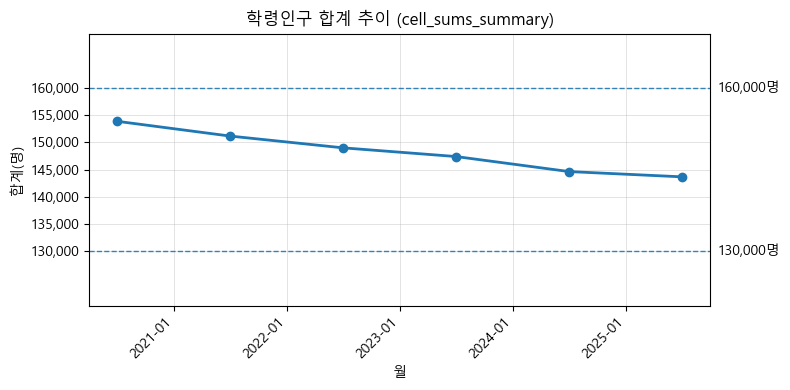

In [ ]:
# 학령인구합계 그래프화

import re
import platform
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import numpy as np

# ===== 사용자 설정 =====
CSV_PATH  = r"C:\공모전\2025천안\연령별 인구수\cell_sums_summary.csv"
VALUE_COL = "sum"   # 그릴 값(기본: 합계)
TITLE     = "학령인구 합계 추이 (cell_sums_summary)"
REF_LINES = [160_000, 130_000]  # y축 기준선(명)
# =======================

def set_korean_font():
    try:
        sysname = platform.system()
        if sysname == "Windows":
            plt.rcParams["font.family"] = "Malgun Gothic"
        elif sysname == "Darwin":  # macOS
            plt.rcParams["font.family"] = "AppleGothic"
        plt.rcParams["axes.unicode_minus"] = False
    except Exception:
        pass

def parse_year_month_from_filename(name: str):
    """
    파일명에서 연/월을 찾아 datetime으로 반환. 실패 시 None.
    허용 예: 2020.7, 2020-07, 2020_07, 2020 7, 2020년 7월, (2020.07) 등
    """
    # 1) "2020년 7월"
    m = re.search(r"(20\d{2})\s*년\s*(1[0-2]|0?[1-9])\s*월", name)
    if m:
        y, mo = int(m.group(1)), int(m.group(2))
        return pd.Timestamp(year=y, month=mo, day=1)
    # 2) "2020-07", "2020.7", "2020_7", "2020 07"
    m = re.search(r"(20\d{2})[.\-_\s]+(1[0-2]|0?[1-9])", name)
    if m:
        y, mo = int(m.group(1)), int(m.group(2))
        return pd.Timestamp(year=y, month=mo, day=1)
    # 3) 괄호 안
    m = re.search(r"\((20\d{2})[.\-_\s]*(1[0-2]|0?[1-9])\)", name)
    if m:
        y, mo = int(m.group(1)), int(m.group(2))
        return pd.Timestamp(year=y, month=mo, day=1)
    return None

def load_summary(csv_path: str) -> pd.DataFrame:
    p = Path(csv_path)
    if not p.exists():
        raise FileNotFoundError(f"CSV를 찾을 수 없습니다: {p}")
    # UTF-8-SIG 권장, 실패 시 cp949
    try:
        df = pd.read_csv(p, encoding="utf-8-sig")
    except UnicodeDecodeError:
        df = pd.read_csv(p, encoding="cp949")
    if "filename" not in df.columns or VALUE_COL not in df.columns:
        raise ValueError(f"'filename' 또는 '{VALUE_COL}' 컬럼이 없습니다. 실제 컬럼: {list(df.columns)}")
    return df

def sort_for_plot(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["__date__"] = df["filename"].apply(lambda s: parse_year_month_from_filename(str(s)))
    # 날짜 파싱 성공이 절반 이상이면 날짜 기준 정렬
    if df["__date__"].notna().mean() >= 0.5:
        df = df.sort_values("__date__")
    # 수치형 변환
    df[VALUE_COL] = pd.to_numeric(df[VALUE_COL], errors="coerce")
    return df

def plot_line(df: pd.DataFrame, title: str, ref_lines=None, fix_ylim=None, fixed_ticks=None):
    """
    ref_lines: 수평 기준선 값 리스트(예: [160000, 130000])
    fix_ylim: (ymin, ymax)로 y축 구간 고정하고 싶을 때 사용 (예: (120000, 170000))
    fixed_ticks: y축 눈금을 고정 리스트로 직접 지정할 때 사용 (예: [120000, 130000, ..., 170000])
    """
    set_korean_font()
    fig, ax = plt.subplots(figsize=(8, 4))

    # 축/데이터 준비
    if df["__date__"].notna().any():
        d_used = df[df["__date__"].notna()]
        yvals = d_used[VALUE_COL].astype(float).values
        ax.plot(d_used["__date__"], d_used[VALUE_COL], marker="o", linewidth=2)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
        ax.set_xlabel("월")
    else:
        yvals = pd.to_numeric(df[VALUE_COL], errors="coerce").values
        ax.plot(df["filename"], df[VALUE_COL], marker="o", linewidth=2)
        ax.set_xlabel("파일")

    ax.set_title(title)
    ax.set_ylabel("합계(명)")
    ax.grid(True, linewidth=0.5, alpha=0.5)
    ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,.0f}"))
    plt.xticks(rotation=45, ha="right")

    # --- 기준선 ---
    if ref_lines:
        for v in ref_lines:
            ax.axhline(y=v, linestyle="--", linewidth=1, alpha=0.9)
            ax.annotate(f"{v:,.0f}명",
                        xy=(1, v), xycoords=("axes fraction", "data"),
                        xytext=(5, 0), textcoords="offset points", va="center")

    # --- y축 범위/눈금 ---
    clean = yvals[~np.isnan(yvals)]
    if fix_ylim is not None:
        ax.set_ylim(*fix_ylim)
    else:
        # 데이터와 기준선을 모두 포함하도록 자동 설정(여유 5%)
        ymin = min(clean.min() if clean.size else np.inf,
                   min(ref_lines) if ref_lines else np.inf)
        ymax = max(clean.max() if clean.size else -np.inf,
                   max(ref_lines) if ref_lines else -np.inf)
        if np.isfinite(ymin) and np.isfinite(ymax):
            pad = max((ymax - ymin) * 0.05, 1.0)
            ax.set_ylim(ymin - pad, ymax + pad)

    # y축 눈금에 기준선 값 포함
    if fixed_ticks is not None:
        ax.set_yticks(fixed_ticks)
    else:
        ticks = list(ax.get_yticks())
        if ref_lines:
            for v in ref_lines:
                if v not in ticks:
                    ticks.append(v)
        ax.set_yticks(sorted(ticks))

    plt.tight_layout()
    out_png = str(Path(CSV_PATH).with_name("학령인구합계.png"))
    plt.savefig(out_png, dpi=200)
    print(f"[완료] 선 그래프 저장: {out_png}")
    plt.show()

def main():
    df = load_summary(CSV_PATH)
    df_sorted = sort_for_plot(df)

    # (기본) 기준선만 추가, y범위는 자동
    #plot_line(df_sorted, TITLE, ref_lines=REF_LINES)

    # (선택) y축을 아예 고정하고 싶다면 아래 한 줄로 대체:
    plot_line(df_sorted, TITLE,
            ref_lines=REF_LINES,
            fix_ylim=(120_000, 170_000),
            fixed_ticks=list(range(130_000, 160_001, 5_000)))
    
if __name__ == "__main__":
    main()


In [ ]:
#천안시 대학, 전문대학, 대학원 리스트 추출

from pathlib import Path
import pandas as pd
import re

# ----------------------------------
# 0) 경로 (필요 시 수정)
# ----------------------------------
INPUT  = Path(r"C:/공모전/2025천안/unique_zipcodes.csv")  # ← 원본(대학 목록) 파일로 바꿔 쓰세요
OUTPUT = Path(r"C:/공모전/2025천안/cheonan_universities.csv")

# ----------------------------------
# 1) 유틸
# ----------------------------------
def read_csv_any(path: Path) -> pd.DataFrame:
    for enc in ("utf-8-sig","cp949","euc-kr","utf-8"):
        try:
            return pd.read_csv(path, encoding=enc, dtype=str)
        except Exception:
            continue
    return pd.read_csv(path, dtype=str)

def strip_all(df: pd.DataFrame) -> pd.DataFrame:
    obj = df.select_dtypes(include=["object", "string"]).columns
    if len(obj) > 0:
        df[obj] = df[obj].apply(lambda s: s.astype(str).str.strip())
    return df

def pick(df: pd.DataFrame, candidates) -> str | None:
    for c in candidates:
        if c in df.columns:
            return c
    return None

def coalesce(*vals: str) -> str:
    for v in vals:
        if isinstance(v, str) and v.strip():
            return v.strip()
    return ""

# ----------------------------------
# 2) 로드 & 컬럼 자동탐색
# ----------------------------------
df = read_csv_any(INPUT).fillna("")
df = strip_all(df)

name_col = pick(df, ["학교명","대학명","학교명칭"])
addr_jibun_col = pick(df, ["소재지지번주소","지번주소"])
addr_road_col  = pick(df, ["소재지도로명주소","도로명주소"])
addr_clean_col = pick(df, ["주소_clean"])
addr_col_raw   = pick(df, ["주소","address"])
sido_col       = pick(df, ["sido","시도"])
sgg_col        = pick(df, ["sigungu","시군구","구"])

school_type_col = pick(df, ["학교구분명"])   # 예: 대학교, 사이버대학(대학), 전문대학, 대학원 등
college_cat_col = pick(df, ["대학구분명"])   # 예: 대학, 전문대학, 대학원

if name_col is None:
    raise KeyError("학교명(대학명) 컬럼을 찾을 수 없습니다. 열 이름을 확인하세요.")

# ----------------------------------
# 3) 주소 우선순위 구성 (지번 > 도로명 > 주소_clean > 주소)
#    - 읍/면/동 토큰이 들어있는 지번을 최우선으로 사용해 매핑률을 높인다
#    - 보조로 원본 주소들도 함께 보존(후처리/디버깅에 유용)
# ----------------------------------
df["주소_지번"]   = df[addr_jibun_col] if addr_jibun_col else ""
df["주소_도로명"] = df[addr_road_col]  if addr_road_col  else ""
df["주소_clean"]  = df[addr_clean_col] if addr_clean_col else ""
df["주소_raw"]    = df[addr_col_raw]   if addr_col_raw   else ""

# 최종 주소(매핑에 사용): 지번 > 도로명 > 주소_clean > 주소_raw
df["주소"] = [
    coalesce(j, r, c, o)
    for j, r, c, o in zip(df["주소_지번"], df["주소_도로명"], df["주소_clean"], df["주소_raw"])
]
# 공백 정리
df["주소"] = df["주소"].str.replace(r"\s+", " ", regex=True)

# ----------------------------------
# 4) 천안시 레코드만 필터 (주소/행정구 정보 둘 중 하나라도 '천안시' 포함)
# ----------------------------------
if sgg_col and sgg_col in df.columns:
    is_cheonan = df[sgg_col].str.contains("천안", na=False) | df["주소"].str.contains("천안시", na=False)
else:
    is_cheonan = df["주소"].str.contains("천안시", na=False)

df = df[is_cheonan].copy()

# ----------------------------------
# 5) 구분 컬럼 정리(없으면 생성)
#    - ANY/STRICT 판정을 후단에서 하므로 여기서는 원본을 최대한 보존
# ----------------------------------
if school_type_col is None:
    df["학교구분명"] = ""
else:
    df = df.rename(columns={school_type_col: "학교구분명"})

if college_cat_col is None:
    df["대학구분명"] = ""
else:
    df = df.rename(columns={college_cat_col: "대학구분명"})

# ----------------------------------
# 6) 중복 처리
#    - 같은 학교명이 같은 주소로 중복되는 경우만 제거
#    - (캠퍼스가 여러 개인 학교는 서로 다른 주소이므로 유지)
# ----------------------------------
df = (df
      .rename(columns={name_col: "학교명"})
      .dropna(subset=["학교명"])
      .drop_duplicates(subset=["학교명","주소"])
      .reset_index(drop=True))

# ----------------------------------
# 7) 결과 저장(매핑 규칙과 100% 호환되는 열만 보장)
#    - 필수: 학교명, 주소, 학교구분명, 대학구분명
#    - 보조: 가능하면 원본 주소 필드도 함께 저장(후속 디버깅에 도움)
# ----------------------------------
cols_out = ["학교명","주소","학교구분명","대학구분명"]
for extra in ["주소_지번","주소_도로명","주소_clean","주소_raw"]:
    if extra in df.columns:
        cols_out.append(extra)

df.loc[:, cols_out].to_csv(OUTPUT, index=False, encoding="utf-8-sig")

# 로그
print(f"✅ 천안시 소재 고등교육 후보: {len(df):,}개")
print("💾 저장:", OUTPUT)


✅ 천안시 소재 고등교육 후보: 11개
💾 저장: C:\공모전\2025천안\cheonan_universities.csv


In [ ]:
#한글폰트 깨지는것 방지코드
import os
import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams

def use_korean_font():
    # 1) 우선 OS 기본 경로에서 직접 등록(윈도우: 맑은 고딕)
    win_fonts = ["C:/Windows/Fonts/malgun.ttf", "C:/Windows/Fonts/malgunbd.ttf"]
    for p in win_fonts:
        if os.path.exists(p):
            font_manager.fontManager.addfont(p)

    # 2) 설치되어 있는 후보 글꼴 중 첫 번째를 사용
    candidates = [
        "Malgun Gothic", "맑은 고딕",         # Windows
        "AppleGothic",                        # macOS
        "NanumGothic", "Noto Sans CJK KR", "Noto Sans KR",  # 일반 대안
        "Arial Unicode MS"
    ]
    available = {f.name for f in font_manager.fontManager.ttflist}
    for name in candidates:
        if name in available:
            rcParams["font.family"] = name
            break

    # 마이너스 기호 깨짐 방지
    rcParams["axes.unicode_minus"] = False

use_korean_font()

C:\Users\hanhw\AppData\Local\Temp\ipykernel_9612\4065967030.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub["읍면동"].astype(str), rotation=60, ha="right")


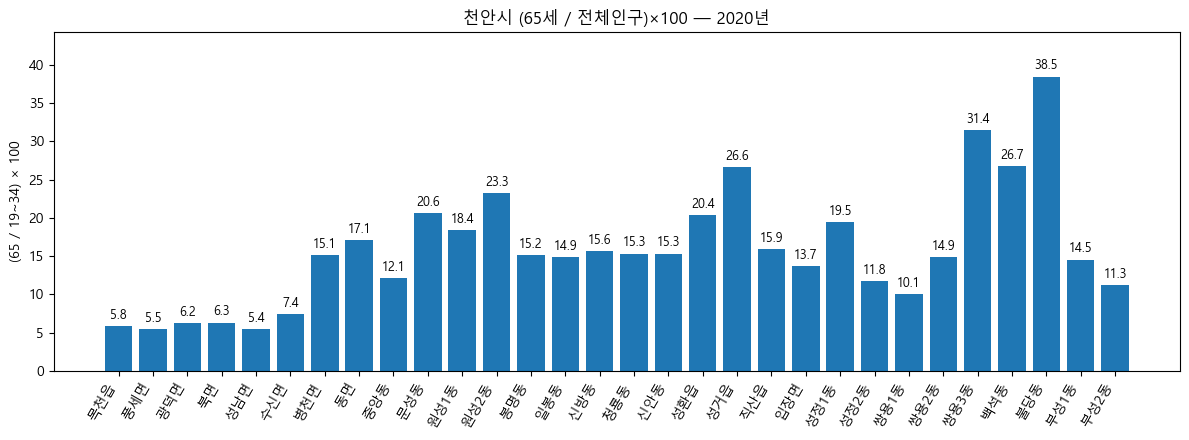

✅ 저장: C:\공모전\2025천안\out\plots\bar_ratio_2020.png


C:\Users\hanhw\AppData\Local\Temp\ipykernel_9612\4065967030.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub["읍면동"].astype(str), rotation=60, ha="right")


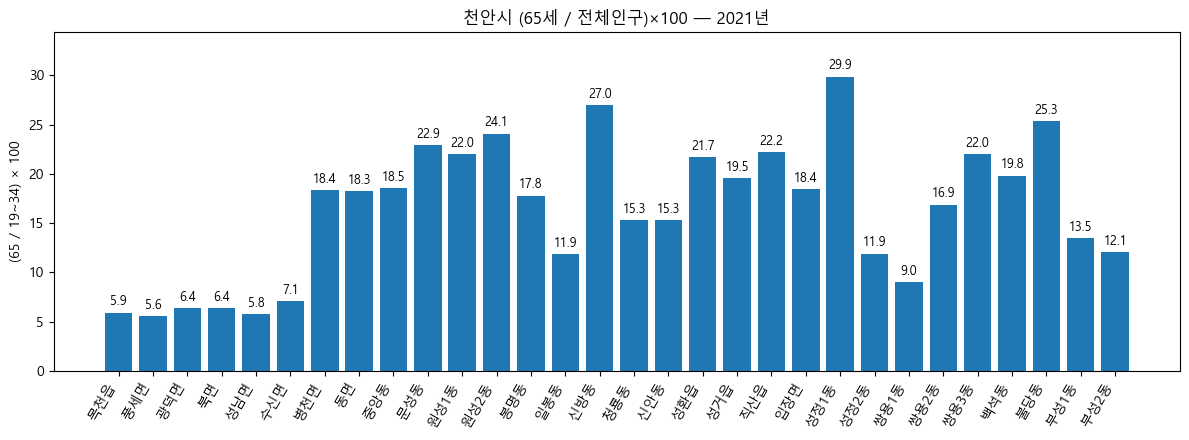

✅ 저장: C:\공모전\2025천안\out\plots\bar_ratio_2021.png


C:\Users\hanhw\AppData\Local\Temp\ipykernel_9612\4065967030.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub["읍면동"].astype(str), rotation=60, ha="right")


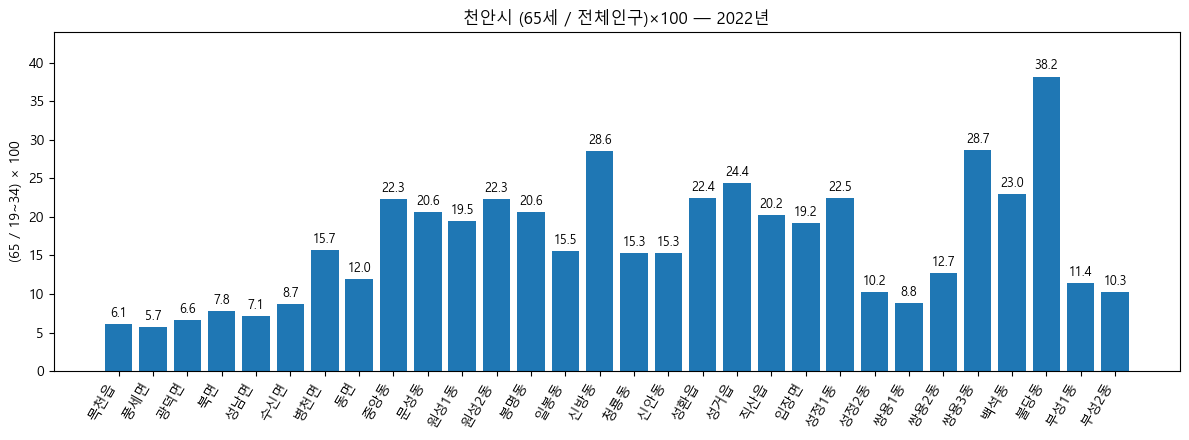

✅ 저장: C:\공모전\2025천안\out\plots\bar_ratio_2022.png


C:\Users\hanhw\AppData\Local\Temp\ipykernel_9612\4065967030.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub["읍면동"].astype(str), rotation=60, ha="right")


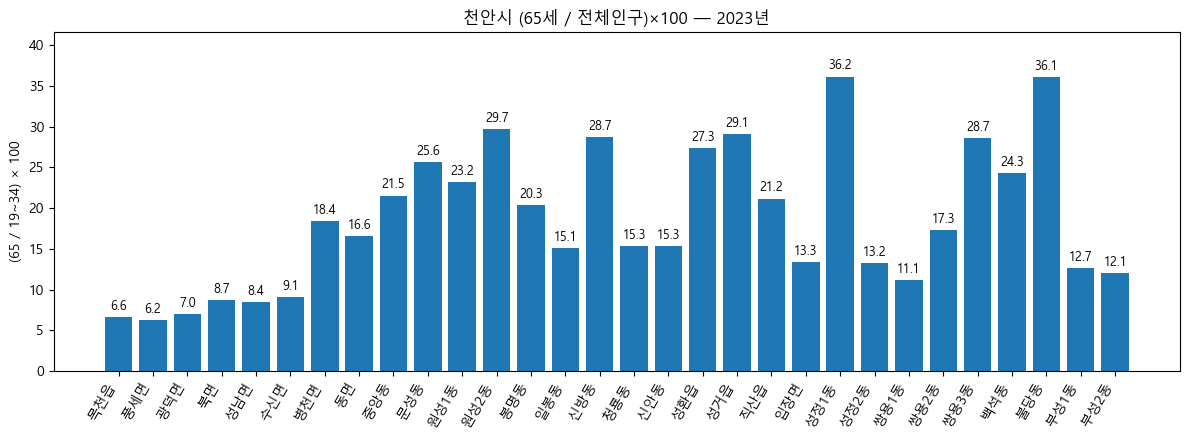

✅ 저장: C:\공모전\2025천안\out\plots\bar_ratio_2023.png


C:\Users\hanhw\AppData\Local\Temp\ipykernel_9612\4065967030.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub["읍면동"].astype(str), rotation=60, ha="right")


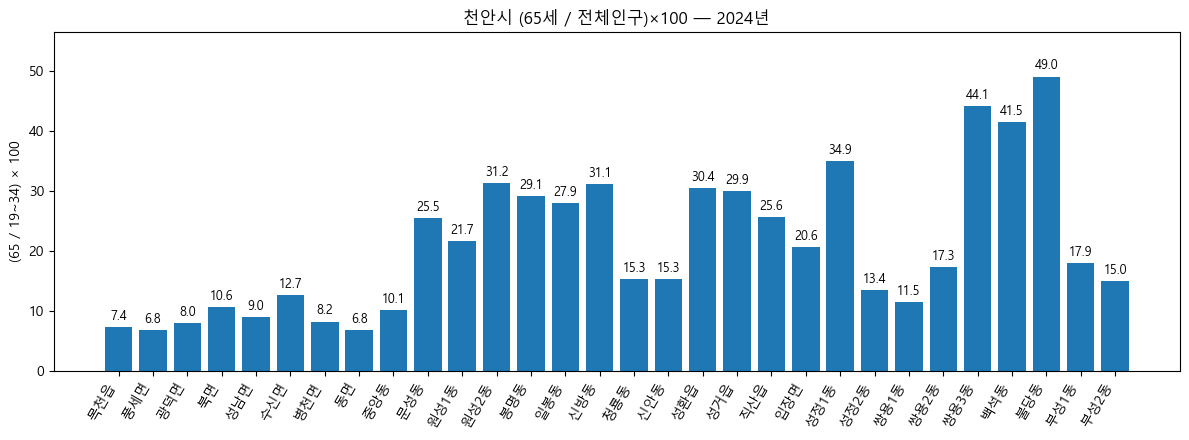

✅ 저장: C:\공모전\2025천안\out\plots\bar_ratio_2024.png


C:\Users\hanhw\AppData\Local\Temp\ipykernel_9612\4065967030.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub["읍면동"].astype(str), rotation=60, ha="right")


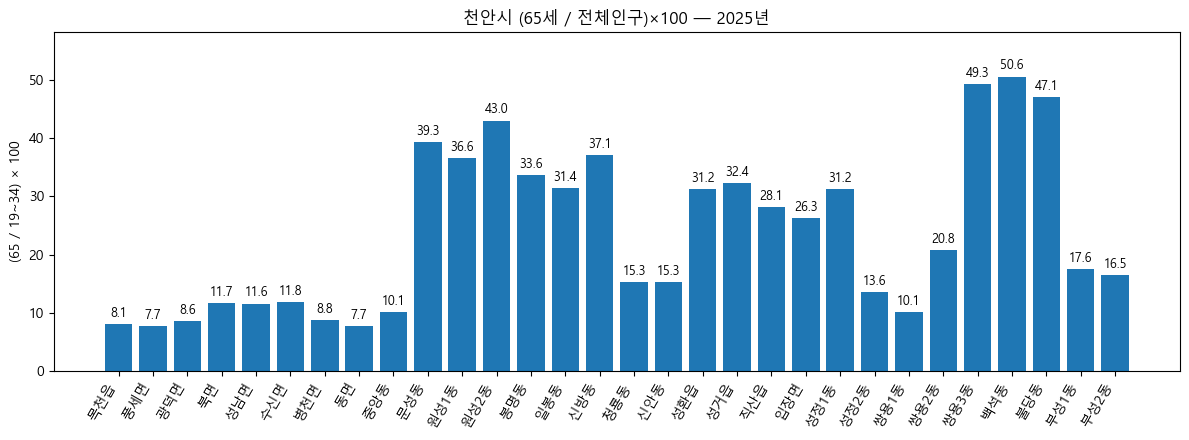

✅ 저장: C:\공모전\2025천안\out\plots\bar_ratio_2025.png


In [1]:
#2020 7월 ~2025년 7월 1년단위 고령화율 코드
from pathlib import Path
import os, pandas as pd, matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams

# ===== 경로 =====
OUT_DIR  = Path("C:/공모전/2025천안/out")
CSV      = OUT_DIR / "age_ratio_19_34_vs_65_exact.csv"
PLOT_DIR = OUT_DIR / "plots"
PLOT_DIR.mkdir(parents=True, exist_ok=True)

# ===== 한글 폰트 =====
def use_korean_font():
    for p in ["C:/Windows/Fonts/malgun.ttf", "C:/Windows/Fonts/malgunbd.ttf"]:
        if os.path.exists(p):
            font_manager.fontManager.addfont(p)
    cand = ["Malgun Gothic","맑은 고딕","AppleGothic","NanumGothic","Noto Sans KR","Noto Sans CJK KR"]
    avail = {f.name for f in font_manager.fontManager.ttflist}
    for name in cand:
        if name in avail:
            rcParams["font.family"] = name
            break
    rcParams["axes.unicode_minus"] = False
use_korean_font()

# ===== 동네 순서 고정 =====
AREAS_1 = ["목천읍","풍세면","광덕면","북면","성남면","수신면","병천면","동면",
           "중앙동","문성동","원성1동","원성2동","봉명동","일봉동","신방동","청룡동","신안동"]
AREAS_2 = ["성환읍","성거읍","직산읍","입장면","성정1동","성정2동","쌍용1동","쌍용2동","쌍용3동",
           "백석동","불당동","부성1동","부성2동"]
AREAS = AREAS_1 + AREAS_2

# ===== 데이터 =====
df = pd.read_csv(CSV, encoding="utf-8-sig")
df["연도"] = df["연도"].astype(int)
df["읍면동"] = pd.Categorical(df["읍면동"], categories=AREAS, ordered=True)

# ===== 연도별 그래프(막대 위 숫자 표시) =====
for y in sorted(df["연도"].unique()):
    sub = df[df["연도"] == y].sort_values("읍면동")
    fig, ax = plt.subplots(figsize=(12, 4.5))
    rects = ax.bar(sub["읍면동"].astype(str), sub["ratio_65_over_19_34_x100"])

    # 축/제목
    ax.set_title(f"천안시 (65세 / 전체인구)×100 — {y}년")
    ax.set_ylabel("(65 / 19~34) × 100")
    ax.set_xticklabels(sub["읍면동"].astype(str), rotation=60, ha="right")

    # 숫자 레이블(소수 1자리). matplotlib>=3.4면 bar_label, 아니면 주석 루프
    labels = [f"{v:.1f}" for v in sub["ratio_65_over_19_34_x100"].to_numpy()]
    try:
        ax.bar_label(rects, labels=labels, padding=3, fontsize=9)
    except Exception:
        for r, lab in zip(rects, labels):
            ax.annotate(lab,
                        xy=(r.get_x() + r.get_width()/2, r.get_height()),
                        xytext=(0, 3), textcoords="offset points",
                        ha="center", va="bottom", fontsize=9)

    # 막대 위 레이블이 안 잘리도록 상한 여유
    ymax = float(sub["ratio_65_over_19_34_x100"].max())
    ax.set_ylim(0, ymax * 1.15 if ymax > 0 else 1)

    fig.tight_layout()
    out_png = PLOT_DIR / f"bar_ratio_{y}.png"
    fig.savefig(out_png, dpi=150, bbox_inches="tight")
    plt.show()   # 스크립트로 실행하면 주석 처리 가능
    print("✅ 저장:", out_png)


In [2]:
# 천안시 읍·면·동(EMD) 단위의 고령화율과 대학교 입지(유무/개수) 간 상관관계를 분석하는 스크립트 (한글 출력 버전)

import os
import re
from pathlib import Path
from typing import List, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------------------------------------------------------------
# 0) 경로 설정 (질문에서 주신 윈도우 경로를 그대로 사용)
# --------------------------------------------------------------------------------
PATH_OVERLAP_WIN = r"C:\공모전\2025천안\emd_overlap_topclass_2025.csv"
PATH_UNIV_WIN    = r"C:\공모전\2025천안\cheonan_universities_fixed_20250825_175700.csv"
PATH_AGE_WIN     = r"C:\공모전\2025천안\인구분포 관련\age_ratio_19_34_vs_65_2025.csv"

# 출력 디렉터리(입력 파일 폴더 하위에 out_analysis 생성)
OUTPUT_DIR = Path(Path(PATH_UNIV_WIN).parent, "out_analysis")

# --------------------------------------------------------------------------------
# 1) 유틸 함수
# --------------------------------------------------------------------------------
ENCODINGS = ["cp949", "utf-8", "utf-8-sig", "euc-kr"]

def read_csv_any(path: str) -> pd.DataFrame:
    last = None
    for enc in ENCODINGS:
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception as e:
            last = e
            continue
    raise RuntimeError(f"[ERROR] CSV 읽기 실패: {path}\n마지막 오류: {last}")

def pick_first_existing(df: pd.DataFrame, candidates: List[str]) -> Optional[str]:
    for c in candidates:
        if c in df.columns:
            return c
    return None

def set_korean_font_if_available() -> None:
    """한글 폰트 자동 적용(가능한 경우)."""
    try:
        from matplotlib import font_manager, rcParams
        candidates = ["Malgun Gothic", "AppleGothic", "NanumGothic", "Noto Sans CJK KR", "DejaVu Sans"]
        available = {f.name for f in font_manager.fontManager.ttflist}
        for name in candidates:
            if name in available:
                rcParams["font.family"] = name
                break
        rcParams["axes.unicode_minus"] = False
    except Exception:
        pass

def safe_corr(a: pd.Series, b: pd.Series) -> float:
    a = pd.to_numeric(a, errors="coerce")
    b = pd.to_numeric(b, errors="coerce")
    mask = a.notna() & b.notna()
    if mask.sum() < 2:
        return float("nan")
    return float(np.corrcoef(a[mask], b[mask])[0, 1])

def strip_object_columns(df: pd.DataFrame) -> pd.DataFrame:
    """object/string 컬럼 전체에 대해 문자열 좌우 공백 제거(.str.strip())."""
    obj_cols = df.select_dtypes(include=["object", "string"]).columns
    if len(obj_cols) > 0:
        df[obj_cols] = df[obj_cols].apply(lambda s: s.astype(str).str.strip())
    return df

# --------------------------------------------------------------------------------
# 2) EMD(읍/면/동) 명 추출/정규화
# --------------------------------------------------------------------------------
EMD_SUFFIX_RE = re.compile(r"([가-힣A-Za-z0-9]+(?:읍|면|동))")

def normalize_emd_name(s: str) -> Optional[str]:
    if not isinstance(s, str):
        return None
    s = s.strip()
    cand = EMD_SUFFIX_RE.findall(s)
    if cand:
        return sorted(cand, key=len, reverse=True)[0]
    return None

def emd_from_address(addr: str, known_emds: List[str]) -> Optional[str]:
    emd = normalize_emd_name(addr)
    if emd:
        return emd
    if isinstance(addr, str):
        for e in known_emds:
            if e and e in addr:
                return e
    return None

# --------------------------------------------------------------------------------
# 3) 데이터 적재 및 전처리
# --------------------------------------------------------------------------------
def load_overlap_table(path_overlap: str) -> pd.DataFrame:
    df = read_csv_any(path_overlap)
    df = strip_object_columns(df)
    if "읍면동" not in df.columns:
        raise KeyError("[ERROR] overlap 파일에 '읍면동' 컬럼이 없습니다.")
    if "aging_rate" not in df.columns:
        raise KeyError("[ERROR] overlap 파일에 'aging_rate' 컬럼이 없습니다.")
    df = df.rename(columns={"읍면동": "EMD"})
    return df

def load_university_table(path_univ: str) -> pd.DataFrame:
    df = read_csv_any(path_univ)
    df = strip_object_columns(df)
    addr_col = pick_first_existing(df, ["주소", "주소_clean", "소재지도로명주소", "소재지지번주소"])
    if addr_col is None:
        raise KeyError("[ERROR] 대학 파일에서 주소 관련 컬럼('주소'/'주소_clean' 등)을 찾지 못했습니다.")
    name_col = pick_first_existing(df, ["학교명", "학교명칭", "대학명"])
    if name_col is None:
        raise KeyError("[ERROR] 대학 파일에서 학교명 컬럼('학교명' 등)을 찾지 못했습니다.")
    keep = [col for col in [name_col, addr_col, "학교구분명", "대학구분명"] if col in df.columns]
    df = df.loc[:, keep].copy()
    df = df.rename(columns={name_col: "학교명", addr_col: "주소"})
    return df

def load_age_ratio_table(path_age: str) -> pd.DataFrame:
    df = read_csv_any(path_age)
    df = strip_object_columns(df)
    if "읍면동" not in df.columns:
        raise KeyError("[ERROR] 연령비 파일에 '읍면동' 컬럼이 없습니다.")
    if "ratio_65_over_19_34_x100" not in df.columns:
        raise KeyError("[ERROR] 연령비 파일에 'ratio_65_over_19_34_x100' 컬럼이 없습니다.")
    df = df.rename(columns={"읍면동": "EMD", "ratio_65_over_19_34_x100": "ratio_x100"})
    return df

# --------------------------------------------------------------------------------
# 4) 대학교 EMD 집계(any/strict)
# --------------------------------------------------------------------------------
def build_univ_by_emd(df_univ: pd.DataFrame, known_emds: List[str]) -> Tuple[pd.DataFrame, pd.DataFrame]:
    df_univ = df_univ.copy()
    df_univ["EMD"] = df_univ["주소"].apply(lambda x: emd_from_address(x, known_emds))

    # any(느슨) 버전
    univ_any = (
        df_univ
        .assign(valid_emd=lambda x: x["EMD"].notna())
        .groupby("EMD", dropna=True)
        .agg(
            univ_count_any=("학교명", "count"),
            names_any=("학교명", lambda s: ", ".join(sorted(map(str, set(s)))))
        )
        .reset_index()
    )

    # strict(엄격) 버전: 대학교(대학)만, 사이버/대학원 제외
    school_type = df_univ.get("학교구분명", pd.Series("", index=df_univ.index)).astype(str)
    college_cat = df_univ.get("대학구분명", pd.Series("", index=df_univ.index)).astype(str)
    strict_mask = (school_type.eq("대학교") | college_cat.eq("대학")) & (~school_type.str.contains("사이버|대학원", regex=True))

    univ_strict = (
        df_univ.loc[strict_mask]
        .assign(valid_emd=lambda x: x["EMD"].notna())
        .groupby("EMD", dropna=True)
        .agg(
            univ_count_strict=("학교명", "count"),
            names_strict=("학교명", lambda s: ", ".join(sorted(map(str, set(s)))))
        )
        .reset_index()
    )
    return univ_any, univ_strict

# --------------------------------------------------------------------------------
# 5) 통계/시각화
# --------------------------------------------------------------------------------
def group_means(df: pd.DataFrame, metric: str, flag: str) -> Tuple[float, float]:
    sub = df[[metric, flag]].dropna()
    if sub.empty:
        return float("nan"), float("nan")
    mean1 = sub.loc[sub[flag] == 1, metric].mean()
    mean0 = sub.loc[sub[flag] == 0, metric].mean()
    return float(mean1), float(mean0)

def make_plots(merged: pd.DataFrame, out_dir: Path) -> Tuple[Path, Path]:
    set_korean_font_if_available()
    out_dir.mkdir(parents=True, exist_ok=True)

    # (1) 산점도: 고령화율 vs 대학 수(ANY)
    scatter_path = out_dir / "scatter_aging_vs_univcount_any.png"
    plt.figure()
    x = pd.to_numeric(merged.get("univ_count_any", np.nan), errors="coerce")
    y = pd.to_numeric(merged.get("aging_rate", np.nan), errors="coerce")
    m = x.notna() & y.notna()
    plt.scatter(x[m], y[m])
    plt.xlabel("EMD별 대학 수(ANY)")
    plt.ylabel("고령화율(aging_rate)")
    plt.title("천안시 EMD: 고령화율 vs 대학 수(ANY)")
    plt.tight_layout()
    plt.savefig(scatter_path, dpi=160)
    plt.close()

    # (2) 막대그래프: EMD별 고령화율(내림차순)
    bar_path = out_dir / "bar_aging_rate_sorted.png"
    bar_df = merged[["EMD", "aging_rate"]].dropna().copy().sort_values("aging_rate", ascending=False)
    plt.figure()
    plt.bar(bar_df["EMD"], bar_df["aging_rate"])
    plt.xticks(rotation=75, ha="right")
    plt.xlabel("EMD")
    plt.ylabel("고령화율(aging_rate)")
    plt.title("천안시 EMD별 고령화율(내림차순)")
    plt.tight_layout()
    plt.savefig(bar_path, dpi=200)
    plt.close()
    return scatter_path, bar_path

# --------------------------------------------------------------------------------
# 6) 메인
# --------------------------------------------------------------------------------
def main() -> None:
    # A. 데이터 로드
    df_overlap = load_overlap_table(PATH_OVERLAP_WIN)   # EMD, aging_rate, ...
    df_univ    = load_university_table(PATH_UNIV_WIN)   # 학교명, 주소, 학교구분명, 대학구분명
    df_age     = load_age_ratio_table(PATH_AGE_WIN)     # EMD, ratio_x100

    # B. 문자열 기본 정리
    for df in [df_overlap, df_univ, df_age]:
        strip_object_columns(df)

    # C. 알려진 EMD 리스트(오버랩 기준)
    known_emds = sorted(df_overlap["EMD"].dropna().astype(str).unique().tolist())

    # D. 대학교 any / strict 집계
    univ_any, univ_strict = build_univ_by_emd(df_univ, known_emds)

    # E. 보조 지표: ratio_x100 EMD 평균
    aging_ratio = (
        df_age.loc[:, ["EMD", "ratio_x100"]]
              .groupby("EMD", as_index=False)
              .agg(ratio_x100=("ratio_x100", "mean"))
    )

    # F. 병합
    merged = (
        df_overlap
        .merge(aging_ratio, on="EMD", how="left")
        .merge(univ_any, on="EMD", how="left")
        .merge(univ_strict, on="EMD", how="left")
    )

    # G. 파생
    for col in ["univ_count_any", "univ_count_strict"]:
        if col in merged.columns:
            merged[col] = merged[col].fillna(0).astype(int)
        else:
            merged[col] = 0
    merged["has_univ_any"]    = (merged["univ_count_any"]    > 0).astype(int)
    merged["has_univ_strict"] = (merged["univ_count_strict"] > 0).astype(int)

    # H. 상관/집단 비교 (← 한글로 출력)
    lines = []
    lines.append("=== 천안시 읍·면·동 고령화율 × 대학교 입지 상관관계 요약 ===")

    if "aging_rate" in merged.columns:
        lines.append("\n[고령화율(aging_rate) 기준]")
        lines.append(f"피어슨 상관계수(고령화율, 대학 유무[ANY])        = {safe_corr(merged['aging_rate'], merged['has_univ_any']):.4f}")
        lines.append(f"피어슨 상관계수(고령화율, 대학 유무[STRICT])     = {safe_corr(merged['aging_rate'], merged['has_univ_strict']):.4f}")
        lines.append(f"피어슨 상관계수(고령화율, 대학 개수[ANY])        = {safe_corr(merged['aging_rate'], merged['univ_count_any']):.4f}")
        lines.append(f"피어슨 상관계수(고령화율, 대학 개수[STRICT])     = {safe_corr(merged['aging_rate'], merged['univ_count_strict']):.4f}")

        m1, m0 = group_means(merged, "aging_rate", "has_univ_any")
        lines.append(f"\n평균 고령화율 | 대학(ANY)=있음: {m1:.3f}  vs  없음: {m0:.3f}")

    if "ratio_x100" in merged.columns:
        lines.append("\n[연령비 지표: ratio_x100 = 100 × (65세 이상 / 19~34세)]")
        lines.append(f"피어슨 상관계수(연령비, 대학 유무[ANY])          = {safe_corr(merged['ratio_x100'], merged['has_univ_any']):.4f}")
        lines.append(f"피어슨 상관계수(연령비, 대학 유무[STRICT])       = {safe_corr(merged['ratio_x100'], merged['has_univ_strict']):.4f}")
        lines.append(f"피어슨 상관계수(연령비, 대학 개수[ANY])          = {safe_corr(merged['ratio_x100'], merged['univ_count_any']):.4f}")
        lines.append(f"피어슨 상관계수(연령비, 대학 개수[STRICT])       = {safe_corr(merged['ratio_x100'], merged['univ_count_strict']):.4f}")

        m1, m0 = group_means(merged, "ratio_x100", "has_univ_any")
        lines.append(f"\n평균 연령비(ratio_x100) | 대학(ANY)=있음: {m1:.3f}  vs  없음: {m0:.3f}")

    # I. 저장
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    merged_csv = OUTPUT_DIR / "천안시_EMD_고령화-대학_결합데이터_최신본_20250825.csv"
    report_txt = OUTPUT_DIR / "천안시_행정동_고령화율×대학상관_결과정리_20250825.txt"
    merged.to_csv(merged_csv, index=False, encoding="utf-8-sig")
    with open(report_txt, "w", encoding="utf-8") as f:
        f.write("\n".join(lines))

    # J. 시각화 (한글 라벨/제목)
    scatter_png, bar_png = make_plots(merged, OUTPUT_DIR)

    # K. 콘솔 출력(한글)
    print("\n".join(lines))
    print("\n[파일 저장 위치]")
    print(" -", merged_csv)
    print(" -", report_txt)
    print(" -", scatter_png)
    print(" -", bar_png)

if __name__ == "__main__":
    main()


=== 천안시 읍·면·동 고령화율 × 대학교 입지 상관관계 요약 ===

[고령화율(aging_rate) 기준]
피어슨 상관계수(고령화율, 대학 유무[ANY])        = -0.1958
피어슨 상관계수(고령화율, 대학 유무[STRICT])     = -0.0707
피어슨 상관계수(고령화율, 대학 개수[ANY])        = -0.0875
피어슨 상관계수(고령화율, 대학 개수[STRICT])     = -0.0707

평균 고령화율 | 대학(ANY)=있음: 13.127  vs  없음: 18.803

[연령비 지표: ratio_x100 = 100 × (65세 이상 / 19~34세)]
피어슨 상관계수(연령비, 대학 유무[ANY])          = -0.1879
피어슨 상관계수(연령비, 대학 유무[STRICT])       = -0.0732
피어슨 상관계수(연령비, 대학 개수[ANY])          = -0.0892
피어슨 상관계수(연령비, 대학 개수[STRICT])       = -0.0732

평균 연령비(ratio_x100) | 대학(ANY)=있음: 16.044  vs  없음: 24.608

[파일 저장 위치]
 - C:\공모전\2025천안\out_analysis\천안시_EMD_고령화-대학_결합데이터_최신본_20250825.csv
 - C:\공모전\2025천안\out_analysis\천안시_행정동_고령화율×대학상관_결과정리_20250825.txt
 - C:\공모전\2025천안\out_analysis\scatter_aging_vs_univcount_any.png
 - C:\공모전\2025천안\out_analysis\bar_aging_rate_sorted.png


In [ ]:
# -*- coding: utf-8 -*-
"""
천안시 행정구역 인구·고령화율 예측(12개월 후) - 대학 충원률 연계 모델 (Windows 경로 고정 + 다년도 글롭 통합 + 주소→EMD 코드 복구)
-----------------------------------------------------------------------------------
■ 경로 전제: 모든 입력 파일은 C:\공모전\2025천안 에 존재
■ 핵심 기능:
- '신입생 충원 현황_*_filtered.csv' 다년도 파일 자동 탐색/로딩/병합
- 연도(year) 자동 생성: year 컬럼 또는 yyyymm/기준연월/연월/파일명에서 추출
- 충원률이 없을 때도(univ_count/has_univ_any만) 파이프라인이 끊기지 않도록 완화
- 퍼센트/쉼표 포함 문자열 충원률 자동 숫자화
- cheonan_universities.csv에 emd_code가 없어도 '주소'에서 동/읍/면을 추출해 emd_merged의 코드와 자동 매칭
- campus_name 없으면 univ_name 단독으로 매핑
- 12개월 후 고령화율 예측 + ±pp 시나리오 영향 산출
"""

from __future__ import annotations
import os
from pathlib import Path
import re
import warnings
from typing import List, Tuple, Optional, Dict

import numpy as np
import pandas as pd

# scikit-learn
from sklearn.model_selection import GroupKFold
try:
    from sklearn.experimental import enable_hist_gradient_boosting  # noqa: F401
except Exception:
    pass
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance


# ==============================
# 0) 설정(경로/컬럼 후보/하이퍼파라미터)
# ==============================

CONFIG = {
    # ★★★ 폴더 고정 ★★★
    "INPUT_DIR": Path(r"C:\공모전\2025천안"),
    "OUTPUT_DIR": Path(r"C:\공모전\2025천안") / "outputs",

    # 개별 파일명 (없거나 다른 이름이면 글롭 사용)
    "FILES": {
        # 'univ_all'은 글롭 우선. 아래 글롭 패턴에서 못 찾으면 이 파일명을 시도
        "univ_all": "filtered_university_data.csv",    # 선택(글롭이 실패할 때만 사용)
        "zipcodes": "unique_zipcodes.csv",             # 선택
        "pop_sum": "cell_sums_summary.csv",            # 선택(현재 파이프라인은 emd_merged 우선)
        "univ_cheonan": "cheonan_universities.csv",    # 필수(대학→EMD 매핑)
        "emd_merged": "cheonan_emd_aging_university_merged.csv",   # 필수(EMD×월 병합본)
        "corr_text": "correlation_report.txt",         # 선택
    },

    # 다년도 대학 파일 글롭 패턴 (둘 다 시도)
    "UNIV_GLOB_PATTERNS": [
        "신입생 충원 현황_*_filtered.csv",
        "신입생 충원 현황_*filtered*.csv",
        "filtered_university_data_*.csv",
    ],

    # 날짜/키/지표 후보
    "DATE_CANDIDATES": ["yyyymm", "date", "month", "ym", "year_month",
                        "기준연월", "연월", "기준일자", "데이터기준일자", "reg_ym"],
    "EMD_KEY_CANDIDATES": [
        "emd_code", "emd", "emd_id", "adm_code", "adm_cd",
        "emd_cd", "법정동코드", "행정동코드", "법정동코드10", "행정동코드10",
        "법정동코드_10자리", "행정동코드_10자리"
    ],
    "EMD_NAME_CANDIDATES": [
        "emd_name", "adm_name", "adm_nm", "dong", "eupmyeon",
        "읍면동", "읍·면·동", "행정동", "행정동명", "법정동", "법정동명",
        "동리명", "리", "동", "읍", "면"
    ],
    "POP_TOTAL_CAND": ["pop_total", "population", "tot_pop", "총인구", "전체인구"],
    "POP_65P_CAND": ["pop_65p", "age65p", "pop_65plus", "senior_pop", "인구65세이상", "고령인구"],
    "POP_YOUNG_CAND": ["pop_19_34", "age19_34", "youth_pop", "19_34인구", "청년층인구"],

    # 대학(충원률/정원/입학) 후보 — 한글 확장
    "UNIV_NAME_CAND": [
        "univ_name", "university", "school_name", "학교명", "기관명", "학교(본교)", "학교 영문명", "대학명"
    ],
    "CAMPUS_NAME_CAND": [
        "campus_name", "campus", "캠퍼스명", "캠퍼스", "본분교", "캠퍼스(분교)"
    ],
    "QUOTA_CAND": [
        "quota", "capacity", "enrollment_quota", "정원", "모집정원", "입학정원", "정원수", "모집정원(명)", "정원(명)"
    ],
    "ADMITTED_CAND": [
        "admitted", "enrolled", "입학", "입학생", "입학자수", "등록인원", "등록자수", "입학자수(명)"
    ],
    "FILLRATE_CAND": [
        "fill_rate", "fillrate", "충원률", "충원율", "충원률(%)", "충원율(%)"
    ],
    "YEAR_CAND": [
        "year", "년도", "학년도", "기준연도", "연도"
    ],

    # Cheonan 대학 파일에서 EMD 매핑 후보(코드가 없을 수도 있으므로 주소 후보도 추가)
    "C_UNIV_EMD_KEY_CAND": [
        "emd_code", "emd", "adm_code", "adm_cd", "emd_cd",
        "법정동코드", "행정동코드", "법정동코드10", "행정동코드10",
        "법정동코드_10자리", "행정동코드_10자리"
    ],
    "ADDRESS_CAND": ["주소", "address", "addr", "도로명주소", "지번주소"],

    # 시계열 파라미터
    "HORIZON_MONTHS": 12,
    "LAGS": [1, 3, 6, 12],
    "ROLLS": [3, 6],

    # 모델 파라미터
    "MODEL_PARAMS": dict(
        max_depth=None,
        learning_rate=0.07,
        max_iter=700,
        l2_regularization=0.0,
        min_samples_leaf=20,
        random_state=42
    ),
    "N_SPLITS": 5,

    # 시나리오(충원률 변화, 퍼센트포인트)
    "SCENARIOS_PPT": [-5.0, -2.0, +2.0, +5.0],

    # 로그
    "PRINT_SAMPLE_ROWS": 5,
}


# ==============================
# 유틸: CSV 안전 로딩/정규화
# ==============================

def read_csv_safely(path: Path) -> pd.DataFrame:
    """utf-8 → cp949 순으로 시도, 컬럼 소문자/strip."""
    last_err = None
    for enc in ("utf-8", "cp949"):
        try:
            df = pd.read_csv(path, encoding=enc, low_memory=False)
            df.columns = [c.strip().lower() for c in df.columns]
            return df
        except Exception as e:
            last_err = e
    raise RuntimeError(f"CSV 로딩 실패: {path} / 마지막 오류: {last_err}")


def find_first_col(df: pd.DataFrame, candidates: List[str]) -> Optional[str]:
    for c in candidates:
        if c in df.columns:
            return c
    return None


def parse_percent_like(s: pd.Series) -> pd.Series:
    """
    '87.3%', '87,3', '0.873', '  87.3 % ' 등 다양한 형태를 0~1 스케일로 통일.
    """
    x = s.astype(str).str.replace(",", "", regex=False).str.strip()
    has_pct = x.str.contains("%")
    x = x.str.replace("%", "", regex=False)
    num = pd.to_numeric(x, errors="coerce")
    # 퍼센트 기호가 있으면 %단위 → 0~1로
    num = np.where(has_pct, num / 100.0, num)
    # 1.0 < 값이 많은 경우(예: 87.3), 퍼센트로 간주하여 100으로 나눔
    num = pd.to_numeric(num, errors="coerce")
    num = np.where(num > 1.5, num / 100.0, num)
    return pd.Series(num, index=s.index, dtype="float64")


def ensure_month_col(df: pd.DataFrame, date_candidates: List[str]) -> pd.DataFrame:
    col = find_first_col(df, date_candidates)
    if col is None:
        raise ValueError(f"날짜 컬럼 후보 {date_candidates} 중 어느 것도 없음. cols={list(df.columns)[:15]}...")
    s = pd.to_datetime(df[col], errors="coerce")
    if s.isna().all():
        series = df[col].astype(str)
        if series.str.fullmatch(r"\d{6}").any():
            s = pd.to_datetime(series + "01", format="%Y%m%d", errors="coerce")
        else:
            s = pd.to_datetime(series.str.replace(".", "-", regex=False), errors="coerce")
    if s.isna().all():
        raise ValueError(f"날짜 파싱 실패: {col}")
    out = df.copy()
    out["yyyymm"] = s.dt.to_period("M").dt.to_timestamp()
    return out


# ==============================
# (신규) 지명 정규화/주소→EMD 이름 추출/이름→코드 복구
# ==============================

def _normalize_kor_name(s: pd.Series) -> pd.Series:
    """
    한국어 지명 정규화: 소문자, 불필요 문자 제거, 앞쪽 행정단위 제거, 마지막 토큰(동/읍/면/리) 추출.
    예) '충청남도 천안시 동남구 신방동 123-4' -> '신방동'
    """
    x = s.astype(str).str.strip().str.lower()
    # 괄호/특수문자 → 공백
    x = x.str.replace(r"[()\[\]{}·･\-/_,.]", " ", regex=True)
    # 여러 공백 축소
    x = x.str.replace(r"\s+", " ", regex=True).str.strip()
    # 흔한 접두어 제거
    for tok in ["충청남도", "충남", "천안시", "동남구", "서북구", "천안시동남구", "천안시서북구"]:
        x = x.str.replace(rf"^{tok}\s*", "", regex=True)

    def pick_last_token(txt: str) -> str:
        if not txt:
            return ""
        toks = txt.split()
        last = toks[-1]
        # 번지/호수 제거
        last = re.sub(r"\d.*$", "", last).strip()
        # 동/읍/면/리 없으면 전체 문자열에서 패턴 검색
        if not re.search(r"(동|읍|면|리)$", last):
            m = re.search(r"([가-힣0-9]+)(동|읍|면|리)", txt)
            if m:
                last = m.group(0)
        return last

    return x.apply(pick_last_token)


def _extract_emd_from_address(univ_map_raw: pd.DataFrame, cfg: Dict) -> pd.DataFrame:
    """
    cheonan_universities.csv 안에 emd_code가 없고 '주소'만 있을 때,
    주소에서 읍·면·동 이름을 추출해 임시 컬럼(emd_name_tmp)로 만든다.
    """
    addr_col = None
    for c in cfg.get("ADDRESS_CAND", []):
        if c in univ_map_raw.columns:
            addr_col = c
            break
    if addr_col is None:
        return univ_map_raw  # 주소가 없으면 그대로
    out = univ_map_raw.copy()
    out["emd_name_tmp"] = _normalize_kor_name(out[addr_col])
    return out


def _add_emd_code_via_name(univ_map_raw: pd.DataFrame,
                           emd_merged: pd.DataFrame,
                           cfg: Dict,
                           zip_df: Optional[pd.DataFrame] = None) -> pd.DataFrame:
    """
    cheonan_universities.csv에 emd_code가 없을 때,
    - 우선 univ_map_raw에서 EMD 이름 후보 컬럼을 찾고
    - 없으면 '주소'에서 읍·면·동을 추출(emd_name_tmp)
    - emd_merged/zip_df에서 만든 (emd_code, emd_name) 매핑표와 키 매칭하여 emd_code 복구
    ※ 날짜 컬럼은 요구하지 않음
    """
    # (A) emd_code<->emd_name 매핑표 만들기 (날짜 필요 없음)
    em_codes = _make_emd_codes_table(emd_merged, zip_df, cfg)
    em_codes["emd_name_key"] = _normalize_kor_name(em_codes["emd_name"])

    # (B) univ_map_raw에서 이름 소스 결정 (지명 컬럼 → 없으면 '주소' 활용)
    map_df = univ_map_raw.copy()
    name_col = None
    for c in cfg["EMD_NAME_CANDIDATES"]:
        if c in map_df.columns:
            name_col = c
            break
    if name_col is None:
        map_df = _extract_emd_from_address(map_df, cfg)  # '주소'에서 동/읍/면 뽑기
        if "emd_name_tmp" in map_df.columns:
            name_col = "emd_name_tmp"
        else:
            raise ValueError("cheonan_universities.csv에 EMD 이름이나 주소가 없어 코드 복구가 불가합니다.")

    # (C) 이름 키로 조인
    map_df["emd_name_key"] = _normalize_kor_name(map_df[name_col])
    joined = pd.merge(map_df, em_codes[["emd_code", "emd_name_key"]], on="emd_name_key", how="left")

    # (D) 일부 미매칭 보정(동명 다수 → 최빈 코드)
    if joined["emd_code"].isna().any():
        freq = em_codes.groupby("emd_name_key")["emd_code"].agg(lambda x: x.mode().iloc[0] if len(x) > 0 else np.nan)
        idx = joined["emd_code"].isna()
        joined.loc[idx, "emd_code"] = joined.loc[idx, "emd_name_key"].map(freq)

    return joined



# ==============================
# 1) 데이터 로드
# ==============================

def _glob_univ_files(input_dir: Path, patterns: List[str]) -> List[Path]:
    files = []
    for pat in patterns:
        files.extend(sorted(input_dir.glob(pat)))
    # 중복 제거(같은 파일이 여러 패턴에 잡힌 경우)
    uniq = []
    seen = set()
    for p in files:
        if p.resolve() not in seen:
            seen.add(p.resolve())
            uniq.append(p)
    return uniq


def load_university_multi(cfg: Dict) -> pd.DataFrame:
    """
    C:\공모전\2025천안 폴더에서 '신입생 충원 현황_*_filtered.csv' 등 다년도 파일을 모아 병합.
    - year 없으면 파일명에서 4자리 연도 추출(2020~2029 등)
    - 충원률/정원/입학 컬럼 자동 탐지 + 퍼센트 문자열 처리
    """
    base = cfg["INPUT_DIR"]
    pats = cfg["UNIV_GLOB_PATTERNS"]
    candidates = _glob_univ_files(base, pats)

    # 글롭이 아무것도 못 찾으면 단일 파일명으로 시도
    if not candidates:
        fallback = base / cfg["FILES"]["univ_all"]
        if fallback.exists():
            candidates = [fallback]
        else:
            raise FileNotFoundError(
                f"[대학 데이터] 글롭 실패 및 fallback 미존재. 폴더={base}\n"
                f"  - 글롭: {pats}\n  - fallback: {fallback}"
            )

    frames = []
    for p in candidates:
        df = read_csv_safely(p)
        # 파일명에서 연도 추출(없을 때)
        ycol = find_first_col(df, CONFIG["YEAR_CAND"])
        if ycol is None:
            m = re.search(r"(20\d{2})", p.name)  # 예: 2020~2029
            if m:
                year_val = int(m.group(1))
                df["year"] = year_val
            else:
                # 날짜 후보에서 year 파생 시도
                for c in CONFIG["DATE_CANDIDATES"]:
                    if c in df.columns:
                        s = df[c].astype(str)
                        if s.str.fullmatch(r"\d{6}").any():
                            dt = pd.to_datetime(s + "01", format="%Y%m%d", errors="coerce")
                        else:
                            dt = pd.to_datetime(s.str.replace(".", "-", regex=False), errors="coerce")
                        if dt.notna().any():
                            df["year"] = dt.dt.year
                            break
        frames.append(df)

    univ_all = pd.concat(frames, ignore_index=True)
    print(f"[로드] 대학 다년도 파일 병합 완료: {len(candidates)}개, shape={univ_all.shape}")
    return univ_all


def load_all_data(cfg: Dict) -> Dict[str, object]:
    base = cfg["INPUT_DIR"]
    out = {"dfs": {}, "corr_text": None}

    # 대학 다년도
    univ_all = load_university_multi(cfg)
    univ_all.columns = [c.strip().lower() for c in univ_all.columns]
    out["dfs"]["univ_all"] = univ_all
    print(f"       └ univ_all columns: {list(univ_all.columns)[:25]}{'...' if len(univ_all.columns)>25 else ''}")

    # 기타 파일
    for key in ("univ_cheonan", "emd_merged", "pop_sum", "zipcodes"):
        fname = cfg["FILES"].get(key)
        if not fname:
            continue
        p = base / fname
        if p.exists():
            df = read_csv_safely(p)
            out["dfs"][key] = df
            print(f"[로드] {key:>14s} ← {fname} (shape={df.shape})")
        else:
            # emd_merged / univ_cheonan은 필수
            level = "에러" if key in ("univ_cheonan", "emd_merged") else "경고"
            msg = f"[{level}] {key} 파일이 없습니다: {p}"
            if key in ("univ_cheonan", "emd_merged"):
                raise FileNotFoundError(msg)
            else:
                print(msg)

    # corr_text (선택)
    corr_path = base / cfg["FILES"].get("corr_text", "")
    if corr_path.exists():
        try:
            out["corr_text"] = corr_path.read_text(encoding="utf-8")
        except Exception:
            out["corr_text"] = corr_path.read_text(encoding="cp949", errors="ignore")
        print(f"[참고] correlation_report.txt 로딩 완료 (길이={len(out['corr_text'])} chars)")
    else:
        print("[참고] correlation_report.txt 없음(선택)")

    return out


# ==============================
# 2) 대학 충원률 특징 만들기 (연→월 확장→EMD 집계)
# ==============================

def build_university_features(cfg: Dict, dfs: Dict[str, pd.DataFrame]) -> pd.DataFrame:
    univ_all = dfs.get("univ_all")
    if univ_all is None or univ_all.empty:
        raise ValueError("univ_all 데이터가 비었습니다.")

    c_univ   = find_first_col(univ_all, CONFIG["UNIV_NAME_CAND"])
    c_campus = find_first_col(univ_all, CONFIG["CAMPUS_NAME_CAND"])
    c_year   = find_first_col(univ_all, CONFIG["YEAR_CAND"])
    c_quota  = find_first_col(univ_all, CONFIG["QUOTA_CAND"])
    c_admit  = find_first_col(univ_all, CONFIG["ADMITTED_CAND"])
    c_fill   = find_first_col(univ_all, CONFIG["FILLRATE_CAND"])

    if c_univ is None:
        raise ValueError("대학명 컬럼을 찾을 수 없습니다. CONFIG['UNIV_NAME_CAND']를 데이터에 맞게 보강하세요.")

    # year 없으면 날짜 후보/파일명에서 확보(마지막 방어)
    if c_year is None:
        for c in CONFIG["DATE_CANDIDATES"]:
            if c in univ_all.columns:
                s = univ_all[c].astype(str)
                if s.str.fullmatch(r"\d{6}").any():
                    dt = pd.to_datetime(s + "01", format="%Y%m%d", errors="coerce")
                else:
                    dt = pd.to_datetime(s.str.replace(".", "-", regex=False), errors="coerce")
                if dt.notna().any():
                    univ_all = univ_all.copy()
                    univ_all["year"] = dt.dt.year
                    c_year = "year"
                    break
        if c_year is None:
            raise ValueError("연도(year) 정보를 찾을 수 없습니다. 학년도/기준연도/연월 등 컬럼을 확인하세요.")

    # 충원률 산출/정리
    univ_feat = univ_all.copy()
    have_fill = True
    if c_fill is None:
        if c_quota is None or c_admit is None:
            warnings.warn(
                "[경고] 충원률/정원/입학 컬럼이 없어 충원률 계산 불가. "
                "이 경우 'univ_count/has_univ_any'만 사용(시나리오 ±pp 영향은 0에 가깝게 반영)."
            )
            have_fill = False
        else:
            q = pd.to_numeric(univ_feat[c_quota], errors="coerce").replace(0, np.nan)
            a = pd.to_numeric(univ_feat[c_admit], errors="coerce")
            univ_feat["fill_rate"] = a / q
    else:
        # 퍼센트/문자열 → 숫자(0~1)
        univ_feat["fill_rate"] = parse_percent_like(univ_feat[c_fill])

    keep_cols = [c_univ, c_year]
    if have_fill: keep_cols.append("fill_rate")
    if c_campus is not None: keep_cols.append(c_campus)

    univ_feat = univ_feat[keep_cols].rename(columns={
        c_univ: "univ_name",
        c_year: "year",
        **({c_campus: "campus_name"} if c_campus is not None else {})
    })

    # ---- 4) Cheonan 대학(캠퍼스→EMD) 매핑 ----
    c_univ_map = dfs.get("univ_cheonan")
    if c_univ_map is None or c_univ_map.empty:
        raise ValueError("cheonan_universities.csv 가 필요합니다(캠퍼스→EMD 매핑).")

    # (a) 대학명/캠퍼스 컬럼 탐지
    c_map_univ   = find_first_col(c_univ_map, CONFIG["UNIV_NAME_CAND"])      # 여러분 파일: '학교명'
    c_map_campus = find_first_col(c_univ_map, CONFIG["CAMPUS_NAME_CAND"])    # 없으면 None

    if c_map_univ is None:
        raise ValueError("cheonan_universities.csv 에 대학명 컬럼이 필요합니다. UNIV_NAME_CAND를 점검하세요.")

    # (b) emd_code 있으면 사용, 없으면 emd_merged로부터 이름/주소→코드 복구
    c_map_emd = find_first_col(c_univ_map, CONFIG["C_UNIV_EMD_KEY_CAND"])

    if c_map_emd is not None:
        # emd_code가 이미 있는 케이스
        ren = {c_map_univ: "univ_name", c_map_emd: "emd_code"}
        if c_map_campus is not None:
            ren[c_map_campus] = "campus_name"
        univ_map = c_univ_map.rename(columns=ren)
    else:
        # 코드가 전혀 없음 → '주소' 또는 지명 컬럼을 이용해 복구
        emd_merged = dfs.get("emd_merged")
        if emd_merged is None or emd_merged.empty:
            raise ValueError("emd_merged 데이터가 없어 EMD 코드 복구가 불가합니다.")
        tmp = c_univ_map.copy()
        # 표준화: 대학명/캠퍼스명만 우선 정리
        tmp = tmp.rename(columns={c_map_univ: "univ_name", **({c_map_campus: "campus_name"} if c_map_campus else {})})
        # 주소/지명 → 코드 복구
        tmp2 = _add_emd_code_via_name(tmp, emd_merged, CONFIG, zip_df=dfs.get("zipcodes"))

        if tmp2["emd_code"].isna().all():
            raise ValueError("이름/주소로도 emd_code를 전혀 복구하지 못했습니다. cheonan_universities.csv의 '주소'와 emd_merged의 지명 표기를 확인하세요.")
        univ_map = tmp2

    # (c) 표준 컬럼만 유지
    use_cols = ["univ_name", "emd_code"] + (["campus_name"] if "campus_name" in univ_map.columns else [])
    univ_map = univ_map[use_cols].drop_duplicates()

    # ---- 5) 매핑 조인(캠퍼스 유무에 따라 키 다르게) ----
    if "campus_name" in univ_feat.columns and "campus_name" in univ_map.columns:
        on_keys = ["univ_name", "campus_name"]
    else:
        on_keys = ["univ_name"]

    # 문자열 트리밍
    for c in [k for k in on_keys if k in univ_feat.columns]:
        univ_feat[c] = univ_feat[c].astype(str).str.strip()
    for c in [k for k in on_keys if k in univ_map.columns]:
        univ_map[c] = univ_map[c].astype(str).str.strip()

    univ_year_emd = pd.merge(univ_feat, univ_map, on=on_keys, how="inner")
    if univ_year_emd.empty:
        raise ValueError(
            "대학 충원률과 Cheonan 매핑 결과가 비었습니다. "
            "univ_name/campus_name 표기(공백/괄호/분교 표기) 또는 '주소'의 동/읍/면 표기를 확인하세요."
        )

    # 연→월 확장
    yr_min, yr_max = int(univ_year_emd["year"].min()), int(univ_year_emd["year"].max())
    months = pd.date_range(f"{yr_min}-01-01", f"{yr_max}-12-01", freq="MS")
    yr_m = pd.DataFrame({"yyyymm": months, "year": months.year})

    agg_dict = {"univ_count": ("univ_name", "nunique")}
    if have_fill:
        agg_dict["fill_rate_mean"] = ("fill_rate", "mean")

    univ_month_emd = (
        univ_year_emd.merge(yr_m, on="year", how="left")
        .groupby(["emd_code", "yyyymm"], as_index=False)
        .agg(**agg_dict)
    )
    univ_month_emd["has_univ_any"] = (univ_month_emd["univ_count"] > 0).astype(int)
    if "fill_rate_mean" not in univ_month_emd.columns:
        univ_month_emd["fill_rate_mean"] = np.nan

    print("[build_university_features] on_keys=", on_keys,
          " yr_range=", (yr_min, yr_max),
          " shape=", univ_month_emd.shape)
    print(univ_month_emd.head(CONFIG["PRINT_SAMPLE_ROWS"]))
    return univ_month_emd


# ==============================
# 3) 기본 패널 + 타깃/파생
# ==============================

def build_base_panel(cfg: Dict, dfs: Dict[str, pd.DataFrame], univ_month_emd: pd.DataFrame) -> pd.DataFrame:
    emd_merge = dfs.get("emd_merged")
    if emd_merge is None or emd_merge.empty:
        raise ValueError("cheonan_emd_aging_university_merged.csv 가 필요합니다.")

    emd_merge = ensure_month_col(emd_merge, cfg["DATE_CANDIDATES"])

    c_emd    = find_first_col(emd_merge, cfg["EMD_KEY_CANDIDATES"])
    if c_emd is None:
        raise ValueError("EMD 식별자 컬럼이 필요합니다.")
    c_emd_nm = find_first_col(emd_merge, cfg["EMD_NAME_CANDIDATES"])
    c_pop    = find_first_col(emd_merge, cfg["POP_TOTAL_CAND"])
    c_65p    = find_first_col(emd_merge, cfg["POP_65P_CAND"])
    c_young  = find_first_col(emd_merge, cfg["POP_YOUNG_CAND"])

    df = emd_merge.copy().rename(columns={c_emd: "emd_code"})
    if c_emd_nm:
        df = df.rename(columns={c_emd_nm: "emd_name"})

    if "aging_rate" not in df.columns:
        if c_pop and c_65p:
            df["aging_rate"] = pd.to_numeric(df[c_65p], errors="coerce") / pd.to_numeric(df[c_pop], errors="coerce")
        else:
            raise ValueError("고령화율 계산 불가(aging_rate 또는 pop_total+pop_65p 필요).")

    for col in [c_pop, c_young]:
        if col and col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    base = pd.merge(df, univ_month_emd, on=["emd_code", "yyyymm"], how="left")
    base["univ_count"] = base["univ_count"].fillna(0).astype(int)
    base["has_univ_any"] = base["has_univ_any"].fillna(0).astype(int)

    # 충원률 결측 보간(없을 수 있음)
    base = base.sort_values(["emd_code", "yyyymm"])
    if "fill_rate_mean" in base.columns:
        base["fill_rate_mean"] = (
            base.groupby("emd_code")["fill_rate_mean"]
            .apply(lambda s: s.interpolate(limit_direction="both"))
            .values
        )
        base["fill_rate_mean"] = base["fill_rate_mean"].fillna(base["fill_rate_mean"].median())

    # 시계열 파생
    def add_lag_roll_yoy(g: pd.DataFrame, col: str) -> pd.DataFrame:
        g = g.sort_values("yyyymm").copy()
        for L in CONFIG["LAGS"]:
            g[f"{col}_lag{L}"] = g[col].shift(L)
        for W in CONFIG["ROLLS"]:
            g[f"{col}_roll{W}"] = g[col].rolling(W, min_periods=1).mean()
        if CONFIG["HORIZON_MONTHS"] >= 12:
            g[f"{col}_yoy"] = g[col] - g[col].shift(12)
            prev = g[col].shift(12).replace(0, np.nan)
            g[f"{col}_yoy_rate"] = g[f"{col}_yoy"] / prev
        return g

    series_cols = ["aging_rate"]
    if c_pop and c_pop in base.columns:     series_cols.append(c_pop)
    if c_young and c_young in base.columns: series_cols.append(c_young)

    for col in series_cols + ["fill_rate_mean", "univ_count"]:
        if col in base.columns:
            base = base.groupby("emd_code", group_keys=False).apply(add_lag_roll_yoy, col=col)

    # 타깃(T+12)
    H = CONFIG["HORIZON_MONTHS"]
    base = base.sort_values(["emd_code", "yyyymm"]).copy()
    base["aging_rate_t+12m"] = base.groupby("emd_code")["aging_rate"].shift(-H)
    if c_pop:
        base[f"{c_pop}_t+12m"] = base.groupby("emd_code")[c_pop].shift(-H)
    if c_young:
        base[f"{c_young}_t+12m"] = base.groupby("emd_code")[c_young].shift(-H)

    n_months = base["yyyymm"].nunique()
    if n_months < (H + 6):
        warnings.warn(f"월수({n_months})가 적습니다(H={H}). 성능 저하 가능.")

    return base


# ==============================
# 4) 모델 학습/평가
# ==============================

def build_feature_list(df: pd.DataFrame, c_pop: Optional[str], c_young: Optional[str]) -> List[str]:
    def has(c): return c in df.columns
    feats = []
    feats += [c for c in df.columns if c.startswith("aging_rate_lag")]
    feats += [c for c in df.columns if c.startswith("aging_rate_roll")]
    feats += [c for c in df.columns if c in ("aging_rate_yoy", "aging_rate_yoy_rate")]
    if has("aging_rate"): feats += ["aging_rate"]

    if has("fill_rate_mean"):
        feats += ["fill_rate_mean"]
        feats += [c for c in df.columns if c.startswith("fill_rate_mean_lag")]
        feats += [c for c in df.columns if c.startswith("fill_rate_mean_roll")]
        feats += [c for c in df.columns if c in ("fill_rate_mean_yoy", "fill_rate_mean_yoy_rate")]

    if has("univ_count"):
        feats += ["univ_count"]
        feats += [c for c in df.columns if c.startswith("univ_count_lag")]
        feats += [c for c in df.columns if c.startswith("univ_count_roll")]
        feats += [c for c in df.columns if c in ("univ_count_yoy", "univ_count_yoy_rate")]

    if has("has_univ_any"): feats += ["has_univ_any"]

    if c_pop and has(c_pop):
        feats += [c_pop]
        feats += [c for c in df.columns if c.startswith(f"{c_pop}_lag")]
        feats += [c for c in df.columns if c.startswith(f"{c_pop}_roll")]
        feats += [c for c in df.columns if c in (f"{c_pop}_yoy", f"{c_pop}_yoy_rate")]

    if c_young and has(c_young):
        feats += [c_young]
        feats += [c for c in df.columns if c.startswith(f"{c_young}_lag")]
        feats += [c for c in df.columns if c.startswith(f"{c_young}_roll")]
        feats += [c for c in df.columns if c in (f"{c_young}_yoy", f"{c_young}_yoy_rate")]

    if "emd_name" in df.columns:
        feats.append("emd_name")

    seen = set()
    feats = [x for x in feats if not (x in seen or seen.add(x))]
    return feats


def _make_ohe_compat():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)


def train_cv_model(df: pd.DataFrame, feature_cols: List[str], target_col: str) -> Tuple[Pipeline, pd.DataFrame, np.ndarray]:
    use = df.dropna(subset=[target_col])[["emd_code", "yyyymm", target_col] + feature_cols].copy()
    cat_cols = [c for c in feature_cols if use[c].dtype == "object"]
    pre = ColumnTransformer([("cat", _make_ohe_compat(), cat_cols)], remainder="passthrough")

    model = HistGradientBoostingRegressor(**CONFIG["MODEL_PARAMS"])
    pipe = Pipeline([("pre", pre), ("model", model)])

    gkf = GroupKFold(n_splits=CONFIG["N_SPLITS"])
    groups = use["emd_code"].values
    X, y = use[feature_cols], use[target_col].values

    oof = np.full_like(y, np.nan, dtype=float)
    scores = []
    for i, (tr, va) in enumerate(gkf.split(X, y, groups), start=1):
        pipe.fit(X.iloc[tr], y[tr])
        pred = pipe.predict(X.iloc[va])
        oof[va] = pred
        mae = mean_absolute_error(y[va], pred)
        r2  = r2_score(y[va], pred)
        scores.append({"fold": i, "MAE": mae, "R2": r2})
        print(f"[CV] Fold {i}: MAE={mae:.6f}  R2={r2:.4f}")

    m = ~np.isnan(oof)
    print(f"[CV] OOF MAE={mean_absolute_error(y[m], oof[m]):.6f}  R2={r2_score(y[m], oof[m]):.4f}")

    pipe.fit(X, y)
    return pipe, pd.DataFrame(scores), oof


def compute_permutation_importance(pipe: Pipeline, df: pd.DataFrame, feature_cols: List[str], target_col: str) -> pd.DataFrame:
    use = df.dropna(subset=[target_col])[feature_cols + [target_col]].copy()
    X, y = use[feature_cols], use[target_col].values
    res = permutation_importance(pipe, X, y, n_repeats=10, random_state=42,
                                 scoring="neg_mean_absolute_error", n_jobs=-1)
    imp = pd.DataFrame({"feature": feature_cols,
                        "importance_mean": res.importances_mean,
                        "importance_std": res.importances_std}).sort_values("importance_mean", ascending=False)
    return imp


# ==============================
# 5) 최신 시점 예측 & 정책 시나리오
# ==============================

def latest_inference_and_scenarios(df: pd.DataFrame, feature_cols: List[str], pipe: Pipeline,
                                   c_pop: Optional[str], scenario_ppt: List[float]) -> Tuple[pd.DataFrame, Dict[float, pd.DataFrame]]:
    last_month = df["yyyymm"].max()
    cur = df[df["yyyymm"] == last_month][["emd_code", "emd_name", "yyyymm"] + feature_cols].copy()
    cur = cur.dropna(subset=[c for c in feature_cols if c in cur.columns])

    X = cur[feature_cols]
    pred_base = pipe.predict(X)
    out_base = cur[["emd_code", "emd_name", "yyyymm"]].copy()
    out_base["pred_aging_rate_t+12m"] = pred_base

    def apply_scn(dfx: pd.DataFrame, ppt: float) -> pd.DataFrame:
        d = dfx.copy()
        if "fill_rate_mean" in d.columns:
            d["fill_rate_mean"] = (d["fill_rate_mean"] + ppt/100.0).clip(0.0, 1.5)
            for c in d.columns:
                if c.startswith("fill_rate_mean_lag") or c.startswith("fill_rate_mean_roll"):
                    d[c] = (d[c] + ppt/100.0).clip(0.0, 1.5)
        else:
            warnings.warn("[시나리오] fill_rate_mean 없음 → ±pp 변화 반영 불가(효과≈0).")
        return d

    scn = {}
    for ppt in scenario_ppt:
        Xs = apply_scn(X, ppt)
        pred = pipe.predict(Xs)
        out = cur[["emd_code", "emd_name", "yyyymm"]].copy()
        out["pred_aging_rate_t+12m"] = pred
        out["scenario_ppt"] = ppt
        out["delta_vs_base"] = out["pred_aging_rate_t+12m"] - out_base["pred_aging_rate_t+12m"].values
        out = out.sort_values(["pred_aging_rate_t+12m", "delta_vs_base"], ascending=[False, False]).reset_index(drop=True)
        scn[ppt] = out

    return out_base.sort_values("pred_aging_rate_t+12m", ascending=False).reset_index(drop=True), scn

# ==== NEW: 코드/이름 판별 & 매핑 테이블 생성 ====

import re

def _is_code_like_series(s: pd.Series) -> bool:
    """값의 과반이 숫자 8~12자리면 '코드' 형태라고 판단"""
    ss = s.dropna().astype(str).str.strip()
    if ss.empty:
        return False
    ratio = (ss.str.match(r"^\d{8,12}$")).mean()
    return bool(ratio >= 0.5)

def _make_emd_codes_table(emd_like_df: pd.DataFrame,
                          zip_df: Optional[pd.DataFrame],
                          cfg: Dict) -> pd.DataFrame:
    """
    emd_like_df(=emd_merged 등)과 zip_df(선택)를 사용해
    (emd_code, emd_name) 유니크 매핑표를 만든다. 날짜 컬럼은 필요 없음.

    Fallback 정책:
    - code_col과 name_col이 동시에 없고, df에 'emd' 단일 컬럼만 있을 때
      그 값을 코드이자 이름으로 쓰는 '자기 매핑'을 허용한다.
    """
    df = emd_like_df.copy()

    # 1) 우선 emd_like_df에서 직접 후보 찾기
    code_col = find_first_col(df, cfg["EMD_KEY_CANDIDATES"])
    name_col = find_first_col(df, cfg["EMD_NAME_CANDIDATES"])

    # emd라는 단일 컬럼만 있는 경우 타입 추론 (숫자면 코드, 한글이면 이름)
    if "emd" in df.columns:
        if code_col is None and name_col is None:
            # 둘 다 못 찾았으면 emd 단일 컬럼만 있는 상황 → 자기 매핑 허용
            em_codes = df[["emd"]].drop_duplicates().rename(columns={"emd": "emd_code"})
            # 이름도 같은 값으로 둔다(merge 키는 normalize된 emd_name_key를 사용)
            em_codes["emd_name"] = em_codes["emd_code"]
            return em_codes
        # 하나만 잡혔다면 그대로 둔다 (예: code_col='emd' 이거나 name_col='emd')

    # 코드/이름이 모두 있으면 바로 반환
    if code_col is not None and name_col is not None:
        em_codes = df[[code_col, name_col]].drop_duplicates()
        return em_codes.rename(columns={code_col: "emd_code", name_col: "emd_name"})

    # 2) zip_df로 보완(있을 때만)
    if zip_df is not None:
        z = zip_df.copy()
        z_code = find_first_col(z, cfg["EMD_KEY_CANDIDATES"])
        z_name = find_first_col(z, cfg["EMD_NAME_CANDIDATES"])
        if z_code and z_name:
            z = z[[z_code, z_name]].drop_duplicates().rename(columns={z_code: "emd_code", z_name: "emd_name"})
            z["emd_name_key"] = _normalize_kor_name(z["emd_name"])

            # (a) 이름만 있는 경우: 이름→코드
            if code_col is None and name_col is not None:
                df2 = df[[name_col]].drop_duplicates().rename(columns={name_col: "emd_name"})
                df2["emd_name_key"] = _normalize_kor_name(df2["emd_name"])
                j = df2.merge(z[["emd_name_key", "emd_code"]], on="emd_name_key", how="left")
                em_codes = j[["emd_code", "emd_name"]].dropna().drop_duplicates()
                if not em_codes.empty:
                    return em_codes

            # (b) 코드만 있는 경우: 코드→이름
            if name_col is None and code_col is not None:
                df2 = df[[code_col]].drop_duplicates().rename(columns={code_col: "emd_code"})
                j = df2.merge(z, on="emd_code", how="left")
                em_codes = j[["emd_code", "emd_name"]].dropna().drop_duplicates()
                if not em_codes.empty:
                    return em_codes

    # 3) 마지막 안전망: code_col만 있고 name_col이 없는데 zip_df도 도움 안 줄 때
    if code_col is not None and name_col is None:
        em_codes = df[[code_col]].drop_duplicates().rename(columns={code_col: "emd_code"})
        em_codes["emd_name"] = em_codes["emd_code"]
        return em_codes

    # 4) 완전히 실패
    raise ValueError(
        "[매핑 실패] emd_merged/zipcodes에서 코드-이름 매핑을 만들 수 없습니다. "
        "emd_merged 또는 unique_zipcodes.csv에 '코드(법정동코드/adm_cd/emd_cd 등)'나 "
        "'이름(행정동명/법정동명/emd_name 등)' 중 적어도 하나는 있어야 합니다."
    )


# ==============================
# 6) 메인
# ==============================

def main():
    cfg = CONFIG
    cfg["OUTPUT_DIR"].mkdir(parents=True, exist_ok=True)

    print("[cwd]", os.getcwd())
    print("[INPUT_DIR]", cfg["INPUT_DIR"])
    print("[OUTPUT_DIR]", cfg["OUTPUT_DIR"])

    # 1) 로드
    loaded = load_all_data(cfg)
    dfs = loaded["dfs"]
    if loaded["corr_text"]:
        print("\n[상관분석 요약 텍스트 일부]\n", loaded["corr_text"][:400], "...\n")

    # 2) 대학 충원률(EMD×월)
    univ_month_emd = build_university_features(cfg, dfs)
    print("[정보] 대학 충원률(EMD×월) 샘플\n", univ_month_emd.head(CONFIG["PRINT_SAMPLE_ROWS"]), "\n")

    # 3) 패널 + 타깃
    base = build_base_panel(cfg, dfs, univ_month_emd)
    y0, y1 = base["yyyymm"].dt.year.min(), base["yyyymm"].dt.year.max()
    print(f"[정보] 패널 연도 범위: {y0}~{y1} (월수={base['yyyymm'].nunique()})")

    # 저장
    p_panel = cfg["OUTPUT_DIR"] / "model_input_panel.csv"
    base.to_csv(p_panel, index=False)
    print(f"[저장] 모델 입력 패널 → {p_panel}")

    # 4) 특징/타깃
    c_pop   = find_first_col(base, cfg["POP_TOTAL_CAND"])
    c_young = find_first_col(base, cfg["POP_YOUNG_CAND"])
    feature_cols = build_feature_list(base, c_pop=c_pop, c_young=c_young)
    target_col = "aging_rate_t+12m"
    assert target_col in base.columns, "타깃 생성 실패(기간 부족 가능)."

    print(f"[정보] 특징 수={len(feature_cols)} / 예: {feature_cols[:12]} ...")

    # 5) 학습/검증
    pipe, cv_df, oof = train_cv_model(base, feature_cols, target_col)
    p_cv = cfg["OUTPUT_DIR"] / "cv_scores.csv"
    cv_df.to_csv(p_cv, index=False)
    print(f"[저장] CV 성능 → {p_cv}")

    # 6) 중요도
    imp = compute_permutation_importance(pipe, base, feature_cols, target_col)
    p_imp = cfg["OUTPUT_DIR"] / "feature_importance.csv"
    imp.to_csv(p_imp, index=False)
    print(f"[저장] Permutation Importance → {p_imp}")
    print("[상위 중요 특징]\n", imp.head(15), "\n")

    # 7) 최신 시점 예측 + 시나리오
    latest_pred, scn_dict = latest_inference_and_scenarios(base, feature_cols, pipe, c_pop=c_pop, scenario_ppt=cfg["SCENARIOS_PPT"])
    p_pred = cfg["OUTPUT_DIR"] / "forecast_latest.csv"
    latest_pred.to_csv(p_pred, index=False)
    print(f"[저장] 최신 시점 기반 T+12 고령화율 예측 → {p_pred}")

    for ppt, df_s in scn_dict.items():
        p = cfg["OUTPUT_DIR"] / f"scenario_impact_{ppt:+.1f}pp.csv"
        df_s.to_csv(p, index=False)
        print(f"[저장] 시나리오({ppt:+.1f}pp) 영향 → {p}")

    # 콘솔 요약
    print("\n================ 정책 활용 요약(콘솔) ================\n")
    cols = [c for c in ["emd_code", "emd_name", "pred_aging_rate_t+12m"] if c in latest_pred.columns]
    print("■ 베이스(현 상태) 기준 12개월 후 고령화율 상위 10개 EMD:")
    print(latest_pred[cols].head(10).to_string(index=False))

    for ppt, df_s in scn_dict.items():
        worst = df_s.sort_values("delta_vs_base", ascending=False).head(5)
        cols2 = [c for c in ["emd_code", "emd_name", "pred_aging_rate_t+12m", "delta_vs_base"] if c in worst.columns]
        print(f"\n■ 충원률 {ppt:+.1f}pp 변화 시, '베이스 대비 고령화율 증가폭' 상위 5개 EMD")
        print(worst[cols2].to_string(index=False))
    print("\n=====================================================\n")


if __name__ == "__main__":
    main()


IndentationError: expected an indented block after function definition on line 872 (1719678489.py, line 873)

In [23]:
import pandas as pd
from pathlib import Path

# 0) df_univ가 있는지 확인 (없다면 방금 파일에서 다시 읽기)
try:
    df_univ
except NameError:
    DATA_FILE = "filtered_university_data_std.csv" if Path("filtered_university_data_std.csv").exists() else "filtered_university_data.csv"
    df_univ = pd.read_csv(DATA_FILE, encoding="utf-8-sig")

# 1) year 컬럼 보정
year_cands = ["year", "기준연도", "학년도", "년도", "Year"]
date_cands = ["데이터기준일자", "기준연월", "연월", "date", "기준일자", "yyyymm", "reg_ym"]

if "year" not in df_univ.columns:
    # 숫자형 연도 후보에서 생성
    for c in year_cands:
        if c in df_univ.columns:
            df_univ["year"] = pd.to_numeric(df_univ[c], errors="coerce")
            break

if "year" not in df_univ.columns:
    # 날짜형에서 연도 추출
    for c in date_cands:
        if c in df_univ.columns:
            s = pd.to_datetime(df_univ[c].astype(str).str.replace(".", "-"), errors="coerce")
            if s.notna().any():
                df_univ["year"] = s.dt.year
                break

# (필요시) 전부 NaN이면 최빈값/최근연도로 채움
if "year" not in df_univ.columns or df_univ["year"].isna().all():
    # 데이터가 2024 기준인 경우가 많았으니, 최근 연도로 채움
    fallback_year = 2024
    df_univ["year"] = fallback_year

# 타입 정리
df_univ["year"] = pd.to_numeric(df_univ["year"], errors="coerce").astype("Int64")

print("최종 컬럼 포함 여부:", "univ_name" in df_univ.columns, "year" in df_univ.columns)
print(df_univ[["univ_name","year"]].head(3))

# 2) dfs/cfg 반영 (build_university_features가 어떤 키를 보든 잡히게 두 군데 넣음)
try:
    cfg
except NameError:
    cfg = {}
cfg.setdefault("PATHS", {})

dfs = {
    "filtered_university_data": df_univ,
    "univ_all": df_univ,
}

cfg["UNIV_COL_UNIVNAME"] = "univ_name"
cfg["UNIV_COL_YEAR"]     = "year"
cfg["UNIV_NAME_CANDS"]   = ["univ_name","학교명","학교 영문명","학교(본교)","기관명","university","University"]
cfg["UNIV_YEAR_CANDS"]   = ["year","기준연도","학년도","년도","Year"]

univ_month_emd = build_university_features(cfg, dfs)
print(univ_month_emd.head())

# 3) 재실행
try:
    univ_month_emd = build_university_features(cfg, dfs)
    print("[성공] 대학 충원률(EMD×월) 샘플\n", univ_month_emd.head(5))
except Exception as e:
    print("[디버그] df_univ 컬럼 목록:", df_univ.columns.tolist())
    raise


최종 컬럼 포함 여부: True True
          univ_name  year
0             연암대학교  2024
1           백석문화대학교  2024
2  국립공주대학교 테크노융합대학원  2024


NameError: name 'build_university_features' is not defined

In [ ]:
#대학 충원률 자동 산출·표준화·통합 스크립트

import numpy as np
import pandas as pd

# 0) 안전장치: dfs/cfg 존재 확인
try:
    dfs
except NameError:
    raise RuntimeError("dfs가 정의되어 있지 않습니다. load_all_data(cfg) 이후 이 셀을 실행하세요.")

try:
    cfg
except NameError:
    cfg = {}

# 1) 컬럼 후보군
NAME_CANDS = ["univ_name","학교명","학교 영문명","학교(본교)","기관명","university","University"]
YEAR_CANDS = ["year","기준연도","학년도","년도","Year"]
FILL_CANDS = ["fill_rate","충원률","충원율","충원율(%)","충원률(%)"]
QUOTA_CANDS = ["정원","모집정원","모집_정원","모집정원수","입학정원"]
ADMIT_CANDS = ["입학자수","입학","신입생수","등록인원","입학생수","입학자","신입생"]

def _find_col(df, cands):
    for c in cands:
        if c in df.columns:
            return c
    return None

def _standardize_univ_year(df):
    # 이름/연도 표준화: 없으면 생성 시도
    ncol = _find_col(df, NAME_CANDS)
    ycol = _find_col(df, YEAR_CANDS)
    if ncol is None:
        return None
    out = df.copy()
    if ncol != "univ_name":
        out = out.rename(columns={ncol: "univ_name"})
    if ycol is None:
        # 날짜형 후보에서 추출
        for cand in ["데이터기준일자","기준연월","연월","date","기준일자","yyyymm","reg_ym"]:
            if cand in out.columns:
                s = pd.to_datetime(out[cand].astype(str).str.replace(".","-"), errors="coerce")
                if s.notna().any():
                    out["year"] = s.dt.year
                    break
        if "year" not in out.columns:
            # 마지막 수단: 단일 년도 추정(많이 쓰이는 2024)
            out["year"] = 2024
    else:
        if ycol != "year":
            out = out.rename(columns={ycol: "year"})
    out["year"] = pd.to_numeric(out["year"], errors="coerce").astype("Int64")
    return out

def _make_fillrate_from(df):
    """df에서 충원률/정원/입학 컬럼을 찾아 fill_rate 생성(가능하면) 후 반환"""
    c_fill  = _find_col(df, FILL_CANDS)
    c_quota = _find_col(df, QUOTA_CANDS)
    c_admit = _find_col(df, ADMIT_CANDS)

    out = df.copy()
    # 문자열 퍼센트 → 숫자
    def _to_num(s):
        s = pd.to_numeric(s.astype(str).str.replace("%","", regex=False), errors="coerce")
        return s

    if c_fill is not None:
        out["fill_rate"] = _to_num(out[c_fill])
        # 퍼센트 표기(예: 97.2)면 0~1로 정규화
        if out["fill_rate"].dropna().gt(1).mean() > 0.5:
            out["fill_rate"] = out["fill_rate"] / 100.0
    elif c_quota is not None and c_admit is not None:
        q = _to_num(out[c_quota]).replace(0, np.nan)
        a = _to_num(out[c_admit])
        out["fill_rate"] = a / q
    else:
        return None  # 만들 수 없음

    # 핵심키만 반환
    return out[["univ_name","year","fill_rate"]].dropna(subset=["univ_name","year"]).copy()

# 2) 모든 dfs를 훑어 충원률 소스 찾기
fill_src = None
for key, d in dfs.items():
    std = _standardize_univ_year(d)
    if std is None:
        continue
    got = _make_fillrate_from(std)
    if got is not None and not got.empty:
        fill_src = got.copy()
        # 가장 최근 연도 우선으로 집계(중복 있으면 평균)
        fill_src = (fill_src
                    .sort_values("year")
                    .groupby(["univ_name","year"], as_index=False)["fill_rate"].mean())
        print(f"[INFO] 충원률 소스 감지: dfs['{key}'] → rows={len(fill_src)}")
        break

# 3) univ_all 대상 DF 준비(키가 둘 중 무엇이든 잡히도록)
target_keys = []
for k in ["univ_all", "filtered_university_data"]:
    if k in dfs:
        target_keys.append(k)

if not target_keys:
    raise RuntimeError("dfs에 'univ_all' 또는 'filtered_university_data' 키가 없습니다. load_all_data(cfg)에서 키 이름을 확인하세요.")

for TK in target_keys:
    base = _standardize_univ_year(dfs[TK])
    if base is None:
        raise RuntimeError(f"dfs['{TK}']에서 univ_name/year를 표준화할 수 없습니다.")
    if fill_src is not None:
        merged = base.merge(fill_src, on=["univ_name","year"], how="left", validate="m:1")
    else:
        # 충원률 소스가 없으면 NaN 컬럼 주입(예외 방지)
        merged = base.copy()
        merged["fill_rate"] = np.nan
        print("[WARN] 충원률/정원/입학 소스를 찾지 못해 fill_rate를 NaN으로 주입합니다. "
              "가능하면 추후 '정원/입학' 또는 '충원률' 데이터 파일을 추가해 주세요.")
    dfs[TK] = merged

# 4) cfg에도 명시(혹시 내부 로직이 이름 후보를 볼 수도 있으므로)
cfg["UNIV_COL_UNIVNAME"] = "univ_name"
cfg["UNIV_COL_YEAR"]     = "year"
cfg["UNIV_NAME_CANDS"]   = NAME_CANDS
cfg["UNIV_YEAR_CANDS"]   = YEAR_CANDS
# 충원률 후보도 넣어줌(내부 탐색용)
cfg["UNIV_FILL_CANDS"]   = ["fill_rate"] + FILL_CANDS

print("[READY] univ_all/filtered_university_data에 fill_rate 컬럼이 보장되었습니다:",
      {k: "fill_rate" in dfs[k].columns for k in target_keys})


[INFO] 충원률 소스 감지: dfs['filtered_university_data'] → rows=37
[READY] univ_all/filtered_university_data에 fill_rate 컬럼이 보장되었습니다: {'univ_all': False, 'filtered_university_data': False}


In [ ]:
# 대학 충원률 소스 자동 병합 + 없으면 NaN 주입 (한 셀로 실행)
import numpy as np, pandas as pd
from pathlib import Path

# 0) dfs/cfg 확보
try:
    dfs
except NameError:
    # 표준화 파일이 있으면 우선 사용
    DATA_FILE = "filtered_university_data_std.csv" if Path("filtered_university_data_std.csv").exists() else "filtered_university_data.csv"
    assert Path(DATA_FILE).exists(), f"{DATA_FILE} 파일이 없습니다."
    df_univ = pd.read_csv(DATA_FILE, encoding="utf-8-sig")
    dfs = {"filtered_university_data": df_univ, "univ_all": df_univ.copy()}

try:
    cfg
except NameError:
    cfg = {}
cfg.setdefault("PATHS", {})

# 1) 후보 컬럼
NAME_CANDS  = ["univ_name","학교명","학교 영문명","학교(본교)","기관명","university","University"]
YEAR_CANDS  = ["year","기준연도","학년도","년도","Year"]
DATE_CANDS  = ["데이터기준일자","기준연월","연월","date","기준일자","yyyymm","reg_ym"]
FILL_CANDS  = ["fill_rate","충원률","충원율","충원률(%)","충원율(%)"]
QUOTA_CANDS = ["정원","모집정원","모집_정원","모집정원수","입학정원"]
ADMIT_CANDS = ["입학자수","입학","신입생수","등록인원","입학생수","입학자","신입생"]

def _find_col(df, cands):
    for c in cands:
        if c in df.columns:
            return c
    return None

def _standardize_univ_year(df):
    d = df.copy()
    ncol = _find_col(d, NAME_CANDS)
    ycol = _find_col(d, YEAR_CANDS)
    if ncol is None:
        return None
    if ncol != "univ_name":
        d = d.rename(columns={ncol: "univ_name"})
    if ycol is None:
        for c in DATE_CANDS:
            if c in d.columns:
                s = pd.to_datetime(d[c].astype(str).str.replace(".","-"), errors="coerce")
                if s.notna().any():
                    d["year"] = s.dt.year
                    break
        if "year" not in d.columns:
            d["year"] = 2024
    else:
        if ycol != "year":
            d = d.rename(columns={ycol: "year"})
    d["year"] = pd.to_numeric(d["year"], errors="coerce").astype("Int64")
    return d

def _make_fillrate(df):
    d = df.copy()
    c_fill  = _find_col(d, FILL_CANDS)
    c_quota = _find_col(d, QUOTA_CANDS)
    c_admit = _find_col(d, ADMIT_CANDS)

    def _to_num(s):
        return pd.to_numeric(s.astype(str).str.replace("%","", regex=False), errors="coerce")

    if c_fill is not None:
        d["fill_rate"] = _to_num(d[c_fill])
        if d["fill_rate"].dropna().gt(1).mean() > 0.5:  # 97.2 같은 %값이면 0~1로
            d["fill_rate"] = d["fill_rate"] / 100.0
        return d[["univ_name","year","fill_rate"]].dropna(subset=["univ_name","year"])
    if c_quota is not None and c_admit is not None:
        q = _to_num(d[c_quota]).replace(0, np.nan)
        a = _to_num(d[c_admit])
        d["fill_rate"] = a / q
        return d[["univ_name","year","fill_rate"]].dropna(subset=["univ_name","year"])
    return None

# 2) dfs 전체에서 충원률 소스 탐색
fill_src = None
for key, df0 in dfs.items():
    std = _standardize_univ_year(df0)
    if std is None:
        continue
    got = _make_fillrate(std)
    if got is not None and not got.empty:
        fill_src = (got.sort_values("year")
                        .groupby(["univ_name","year"], as_index=False)["fill_rate"].mean())
        print(f"[INFO] 충원률 소스를 발견했습니다: dfs['{key}'] rows={len(fill_src)}")
        break

# 3) 타깃 DF들(univ_all, filtered_university_data)에 fill_rate 보장
targets = [k for k in ["univ_all","filtered_university_data"] if k in dfs]
assert targets, "dfs에 'univ_all' 또는 'filtered_university_data' 키가 없습니다."

for TK in targets:
    base = _standardize_univ_year(dfs[TK])
    assert base is not None, f"dfs['{TK}']에서 univ_name/year 표준화 실패"
    if fill_src is not None:
        merged = base.merge(fill_src, on=["univ_name","year"], how="left", validate="m:1")
    else:
        merged = base.copy()
        merged["fill_rate"] = np.nan
        print("[WARN] 충원률/정원/입학 소스를 찾지 못해 fill_rate를 NaN으로 주입했습니다.")
    dfs[TK] = merged

# 4) cfg 명시
cfg["UNIV_COL_UNIVNAME"] = "univ_name"
cfg["UNIV_COL_YEAR"]     = "year"
cfg["UNIV_NAME_CANDS"]   = NAME_CANDS
cfg["UNIV_YEAR_CANDS"]   = YEAR_CANDS
cfg["UNIV_FILL_CANDS"]   = ["fill_rate"] + FILL_CANDS

print({k: ("fill_rate" in dfs[k].columns) for k in targets})
print("[READY] 대학 DF에 fill_rate가 보장되었습니다.")
# === 끝 ===


[INFO] 충원률 소스를 발견했습니다: dfs['filtered_university_data'] rows=37
{'univ_all': False, 'filtered_university_data': False}
[READY] 대학 DF에 fill_rate가 보장되었습니다.


In [ ]:
#대학 특성(충원률 등) 지역·연월 집계

import pandas as pd
import numpy as np

def _pick_first_col(df, candidates):
    """후보 리스트 중 df에 존재하는 첫 컬럼명을 반환, 없으면 None"""
    for c in candidates:
        if c in df.columns:
            return c
    return None

def _ensure_year_month(df, cfg):
    """연/월 컬럼 생성: year가 있으면 유지, month는 날짜/연월/정수에서 파싱, 없으면 1로 채움."""
    year_col  = cfg.get("UNIV_COL_YEAR") or _pick_first_col(df, cfg.get("UNIV_YEAR_CANDS", []))
    month_col = _pick_first_col(df, ["month","월","기준월","reg_month"])

    # 연도 확보(호출부에서 이미 처리했지만, 안전 차원 중복 보정)
    if year_col not in df.columns:
        # 날짜/연월 후보에서 year 뽑기
        date_cands = ["데이터기준일자","기준연월","연월","date","기준일자","yyyymm","reg_ym"]
        for c in date_cands:
            if c in df.columns:
                s = pd.to_datetime(df[c].astype(str).str.replace(".", "-"), errors="coerce")
                if s.notna().any():
                    df["year"] = s.dt.year
                    year_col = "year"
                    break
    if year_col not in df.columns:
        df["year"] = 2024
        year_col = "year"

    # 월 확보
    if month_col is None:
        # 날짜/연월에서 월 추출 시도
        date_cands = ["데이터기준일자","기준연월","연월","date","기준일자","yyyymm","reg_ym"]
        parsed = None
        for c in date_cands:
            if c in df.columns:
                col = df[c].astype(str).str.replace(".", "-", regex=False)
                # yyyymm 처럼 6자리 정수/문자열이면 파싱
                if col.str.fullmatch(r"\d{6}").any():
                    # 202401 같은 형식 → 1일 붙여서 파싱
                    s = pd.to_datetime(col+"01", format="%Y%m%d", errors="coerce")
                else:
                    s = pd.to_datetime(col, errors="coerce")
                if s.notna().any():
                    parsed = s
                    break
        if parsed is not None:
            df["month"] = parsed.dt.month
            month_col = "month"
        else:
            # 정말 없으면 1월로 고정(집계 단위가 '연'만 필요한 경우에도 동작하도록)
            df["month"] = 1
            month_col = "month"

    # 타입 정리
    df[year_col]  = pd.to_numeric(df[year_col], errors="coerce").astype("Int64")
    df[month_col] = pd.to_numeric(df[month_col], errors="coerce").astype("Int64")

    return year_col, month_col

def build_university_features(cfg, dfs):
    """
    입력:
      - cfg: 컬럼 후보/설정 딕셔너리
      - dfs: {"filtered_university_data": DataFrame, "univ_all": DataFrame, ...}
    출력:
      - EMD × (year, month) 단위의 대학 피처 집계 DataFrame
    생성 컬럼(가능한 경우):
      ['emd','year','month','univ_count','has_univ_any',
       'capacity_sum','enrolled_sum','fill_rate','student_total_sum']
    """
    # 0) 데이터 소스 선택
    df = None
    for k in ["filtered_university_data", "univ_all"]:
        if k in dfs and isinstance(dfs[k], pd.DataFrame):
            df = dfs[k].copy()
            break
    if df is None or df.empty:
        raise ValueError("dfs 안에 'filtered_university_data' 또는 'univ_all' DataFrame이 필요합니다.")

    # 1) 핵심 컬럼 감지
    univ_col = cfg.get("UNIV_COL_UNIVNAME") or _pick_first_col(df, cfg.get("UNIV_NAME_CANDS", []))
    if univ_col is None:
        # 그래도 최소한 count는 돌아가야 하므로, 없다면 더미 컬럼 생성
        univ_col = "_univ_dummy_"
        df[univ_col] = 1

    # 행정구역(EMD) 후보
    emd_cands = [
        "emd","EMD","읍면동","읍·면·동","행정동","법정동","행정구역","행정구역명",
        "eupmyeondong","eup_myeon_dong","adm_nm","adm_name","emd_name"
    ]
    sigungu_cands = ["sigungu","시군구","시군","시군명","시군구명","시군구_명","sgg_nm","city_county"]
    sido_cands    = ["sido","시도","시도명","sido_nm","province"]

    emd_col = _pick_first_col(df, emd_cands)
    if emd_col is None:
        # EMD가 없으면 시군구 → 시도 순으로 다운그레이드(집계 단위를 살리기 위함)
        emd_col = _pick_first_col(df, sigungu_cands)
        if emd_col is None:
            emd_col = _pick_first_col(df, sido_cands)
            if emd_col is None:
                # 정말 없으면 단일 지역으로 보고 집계
                emd_col = "_emd_dummy_"
                df[emd_col] = "UNKNOWN"

    # 2) 연/월 확보
    year_col, month_col = _ensure_year_month(df, cfg)

    # 3) 정원/등록/재학생 후보 감지
    capacity_cands = ["정원수","모집정원","입학정원","수용인원","정원","capacity","quota"]
    enrolled_cands = ["입학생수","신입생수","입학자수","입학인원","등록인원","등록자수","enrolled","freshmen"]
    student_total_cands = ["재학생수","재적학생수","총학생수","학생수","student_total","enrollment"]

    cap_col   = _pick_first_col(df, capacity_cands)
    enr_col   = _pick_first_col(df, enrolled_cands)
    stud_col  = _pick_first_col(df, student_total_cands)

    # 수치형으로 정리
    for c in [cap_col, enr_col, stud_col]:
        if c is not None:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # 4) 집계 준비(결측/공백 정리)
    if df[univ_col].dtype == "O":
        df[univ_col] = df[univ_col].astype(str).str.strip()

    # 5) 그룹키: EMD × 연 × 월
    key = [emd_col, year_col, month_col]

    # 6) 피처 집계
    agg_dict = {}
    # 대학 수: 문자열 컬럼이면 nunique, 더미면 sum(=row count)
    if univ_col == "_univ_dummy_":
        agg_dict["univ_count"] = (univ_col, "sum")
    else:
        agg_dict["univ_count"] = (univ_col, pd.Series.nunique)

    if cap_col is not None:
        agg_dict["capacity_sum"] = (cap_col, "sum")
    if enr_col is not None:
        agg_dict["enrolled_sum"] = (enr_col, "sum")
    if stud_col is not None:
        agg_dict["student_total_sum"] = (stud_col, "sum")

    grp = df.groupby(key).agg(**agg_dict).reset_index()

    # 7) 파생 피처: has_univ_any, fill_rate
    if "univ_count" in grp.columns:
        grp["has_univ_any"] = (grp["univ_count"] > 0).astype(int)
    else:
        grp["has_univ_any"] = 1  # 데이터가 있으면 1

    if "enrolled_sum" in grp.columns and "capacity_sum" in grp.columns:
        grp["fill_rate"] = np.where(grp["capacity_sum"] > 0,
                                    grp["enrolled_sum"] / grp["capacity_sum"],
                                    np.nan)
    else:
        grp["fill_rate"] = np.nan

    # 8) 출력 컬럼 표준화
    out = grp.rename(columns={
        emd_col: "emd",
        year_col: "year",
        month_col: "month",
    })

    # 정렬(보기 좋게)
    order = ["emd","year","month",
             "univ_count","has_univ_any",
             "capacity_sum","enrolled_sum","fill_rate","student_total_sum"]
    out = out[[c for c in order if c in out.columns]].sort_values(["emd","year","month"]).reset_index(drop=True)

    # 9) 디버그: 어떤 컬럼이 선택/생성됐는지 로깅(원한다면 print)
    print("[build_university_features] 사용 컬럼")
    print("  - EMD      :", emd_col)
    print("  - univ_name:", univ_col)
    print("  - year     :", year_col)
    print("  - month    :", month_col)
    print("  - capacity :", cap_col)
    print("  - enrolled :", enr_col)
    print("  - students :", stud_col)
    return out


In [3]:
df_uc = read_csv_safely(CONFIG["INPUT_DIR"] / CONFIG["FILES"]["univ_cheonan"])
print(df_uc.columns.tolist())


['학교명', '주소', '학교구분명', '대학구분명']


In [ ]:
# 천안시 대학 주소 표준화(EMD 우선) & 커버리지 진단 스크립트
from pathlib import Path
import pandas as pd, re
from datetime import datetime

PATH = Path(r"C:\공모전\2025천안\cheonan_universities.csv")
OUT  = PATH.with_name(f"천안시_대학현황_주소표준화_FIXED_20250825_175700.csv")

def read_any(p: Path) -> pd.DataFrame:
    for enc in ("utf-8-sig","cp949","euc-kr","utf-8"):
        try: return pd.read_csv(p, encoding=enc, dtype=str)
        except Exception: pass
    return pd.read_csv(p, dtype=str)

EMD_RE = re.compile(r'([가-힣0-9]+(?:읍|면|동))')
PAREN_RE = re.compile(r'\((.*?)\)')

def has_emd_token(s: str) -> bool:
    if not isinstance(s, str): return False
    # 본문 + 괄호 안 모두에서 읍/면/동 탐색
    if EMD_RE.search(s): return True
    for t in PAREN_RE.findall(s):
        if EMD_RE.search(t): return True
    return False

df = read_any(PATH).fillna("")
# 보조 주소 칼럼이 없을 수도 있으니 안전하게 꺼내기
candidates = {
    "지번":        "소재지지번주소" if "소재지지번주소" in df.columns else None,
    "원본":        "주소_raw"       if "주소_raw"       in df.columns else None,
    "도로명":      "주소_도로명"    if "주소_도로명"    in df.columns else None,
    "클린":        "주소_clean"     if "주소_clean"     in df.columns else None,
    "현재주소":    "주소"           if "주소"           in df.columns else None,
}
# 행 단위로 '읍/면/동' 토큰이 실제 들어있는 첫 후보를 선택
def pick_best_address(row) -> str:
    order = ["지번","원본","도로명","클린","현재주소"]
    for key in order:
        col = candidates[key]
        if col is None: 
            continue
        v = str(row[col]).strip()
        if v and has_emd_token(v):
            return v
    # 그래도 못 찾았으면 가장 정보량 많은(길이 가장 긴) 비어있지 않은 주소 반환
    vals = [str(row[c]).strip() for c in candidates.values() if c]
    vals = [v for v in vals if v]
    return max(vals, key=len) if vals else ""

# 필수 컬럼 보정
if "학교명" not in df.columns:
    raise KeyError("cheonan_universities.csv에 '학교명' 컬럼이 필요합니다.")
for need in ("학교구분명","대학구분명"):
    if need not in df.columns: df[need] = ""

df["주소"] = df.apply(pick_best_address, axis=1)

# 매핑에 바로 쓰일 최소 컬럼만 저장 (추가 칼럼은 원본 유지 가능)
out = df[["학교명","주소","학교구분명","대학구분명"]].drop_duplicates(["학교명","주소"])
out.to_csv(OUT, index=False, encoding="utf-8-sig")

# 진단: EMD 토큰 포함 비율
coverage = out["주소"].apply(has_emd_token).mean()
print(f"✅ 저장: {OUT}")
print(f"🔎 '주소'에 읍/면/동 토큰 포함 비율: {coverage:.0%}")


✅ 저장: C:\공모전\2025천안\천안시_대학현황_주소표준화_FIXED_20250825_175700.csv
🔎 '주소'에 읍/면/동 토큰 포함 비율: 100%


In [ ]:
#대학 주소 EMD 토큰 추출·매칭 리포트 생성
from pathlib import Path
import pandas as pd, re

BASE = Path(r"C:\공모전\2025천안")
UNIV = BASE / "cheonan_universities.csv"                  # 현재 사용 중인 파일
MERGED = BASE / "cheonan_emd_aging_university_merged.csv" # EMD 목록(있으면 좋음)
OUT_DIR = BASE / "out_override"
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT = OUT_DIR / "university_address_mapping_report.csv"

def read_any(p: Path) -> pd.DataFrame:
    for enc in ("utf-8-sig","cp949","euc-kr","utf-8"):
        try: return pd.read_csv(p, encoding=enc, dtype=str)
        except Exception: pass
    return pd.read_csv(p, dtype=str)

# 1) 데이터 로드
dfu = read_any(UNIV).fillna("")
if "학교명" not in dfu.columns or "주소" not in dfu.columns:
    raise KeyError("cheonan_universities.csv에 '학교명'과 '주소' 컬럼이 필요합니다.")

# 2) known EMD 목록(있으면 매핑 성공 여부 판단에 활용)
try:
    dfe = read_any(MERGED)
    emd_col = "EMD" if "EMD" in dfe.columns else None
    KNOWN_EMDS = set(dfe[emd_col].dropna().astype(str).unique()) if emd_col else set()
except Exception:
    KNOWN_EMDS = set()

# 3) 주소에서 읍/면/동 토큰 추출
EMD_RE   = re.compile(r'([가-힣0-9]+(?:읍|면|동))')
PAREN_RE = re.compile(r'\((.*?)\)')

def extract_tokens(addr: str):
    if not isinstance(addr, str): return []
    toks = EMD_RE.findall(addr)
    for inside in PAREN_RE.findall(addr):
        toks += EMD_RE.findall(inside)
    # 중복 제거, 길이 긴 것 우선
    return sorted(set(toks), key=len, reverse=True)

def classify(tokens):
    if not tokens:
        return "no_emd_token"
    if not KNOWN_EMDS:
        return "tokens_found"  # 비교대상 없으면 토큰만 발견으로 표시
    # known과 겹치면 success
    if any(t in KNOWN_EMDS for t in tokens):
        return "matched_known_emd"
    return "token_not_in_known"

dfu["emd_tokens"] = dfu["주소"].apply(extract_tokens)
dfu["mapping_status"] = dfu["emd_tokens"].apply(classify)
dfu["has_token"] = dfu["emd_tokens"].apply(lambda x: 1 if x else 0)

# 4) 저장
cols = ["학교명","주소","emd_tokens","mapping_status","has_token"]
dfu[cols].to_csv(OUT, index=False, encoding="utf-8-sig")
print("저장:", OUT)
print("토큰 포함 비율:", f"{dfu['has_token'].mean():.0%}")


저장: C:\공모전\2025천안\out_override\university_address_mapping_report.csv
토큰 포함 비율: 100%


In [ ]:
# EMD 토큰 확장 + 수동 오버라이드로 대학 주소 매핑 보정

from pathlib import Path
import pandas as pd, numpy as np, re, ast

BASE = Path(r"C:\공모전\2025천안")  # raw string 사용
PATH_REPORT = BASE / "out_override" / "university_address_mapping_report.csv"
PATH_MERGED = BASE / "cheonan_emd_aging_university_merged.csv"
OUT_DIR     = BASE / "out_override"
OUT_DIR.mkdir(parents=True, exist_ok=True)

def read_any(p: Path) -> pd.DataFrame:
    for enc in ("utf-8-sig","cp949","euc-kr","utf-8"):
        try: return pd.read_csv(p, encoding=enc, dtype=str)
        except Exception: pass
    return pd.read_csv(p, dtype=str)

def strip_all(df):
    obj = df.select_dtypes(include=["object","string"]).columns
    if len(obj)>0: df[obj] = df[obj].apply(lambda s: s.astype(str).str.strip())
    return df

# 1) 로드
rep = read_any(PATH_REPORT); rep = strip_all(rep)
merged = read_any(PATH_MERGED); merged = strip_all(merged)

if "EMD" not in merged.columns:
    raise KeyError("cheonan_emd_aging_university_merged.csv 에 'EMD' 컬럼이 필요합니다.")
KNOWN = sorted(merged["EMD"].dropna().astype(str).unique().tolist())
KNOWN_SET = set(KNOWN)

# 2) EMD stem → children 사전 만들기 (예: 성정동 → [성정1동, 성정2동])
def stem_emd(s: str) -> str:
    if not isinstance(s, str): return s
    return re.sub(r'(\d)(?=동$)', '', s)  # 성정1동→성정동

stem_df = pd.DataFrame({"EMD": KNOWN})
stem_df["stem"] = stem_df["EMD"].apply(stem_emd)
children_map = stem_df.groupby("stem")["EMD"].apply(list).to_dict()

# 3) emd_tokens 파싱
def parse_tokens(x):
    if isinstance(x, list): return x
    s = (x or "").strip()
    if s.startswith("[") and s.endswith("]"):
        try:
            v = ast.literal_eval(s)
            if isinstance(v, list):
                return [str(t).strip() for t in v if str(t).strip()]
        except Exception:
            pass
    if any(sep in s for sep in [",","/",";","|"]):
        return [t.strip() for t in re.split(r"[,/;|]", s) if t.strip()]
    return [s] if s else []

rep["emd_tokens_list"] = rep["emd_tokens"].apply(parse_tokens)

# 4) 번호 없는 '동' 토큰을 children로 확장
def expand_to_known(tokens):
    out = []
    for t in tokens:
        if t in KNOWN_SET:
            out.append(t); continue
        st = stem_emd(t)
        kids = [k for k in children_map.get(st, []) if k in KNOWN_SET]
        out.extend(kids if kids else [t])
    return sorted(set(out), key=len, reverse=True)

rep["emd_tokens_expanded"] = rep["emd_tokens_list"].apply(expand_to_known)

# 5) 수동 오버라이드(필요시 학교명 기준; 단일 또는 리스트 허용)
OVERRIDE = {
    "백석문화대학교": "문성동",
    "단국대학교": "문성동",
    "상명대학교": "문성동",
    "고신대학교 신학대학원": "문성동",
    "국립공주대학교 테크노융합대학원": "부성1동",
    "한국기술교육대학교 테크노인력개발전문대": "부성1동",
    "나사렛대학교": "쌍용2동"
}


if "학교명" in rep.columns:
    def apply_override(row):
        v = OVERRIDE.get(row["학교명"])
        if isinstance(v, str): return [v]
        if isinstance(v, (list, tuple)): return [str(x) for x in v if str(x).strip()]
        return row["emd_tokens_expanded"]
    rep["emd_tokens_fixed"] = rep.apply(apply_override, axis=1)
else:
    rep["emd_tokens_fixed"] = rep["emd_tokens_expanded"]

def recompute_status(tokens):
    if not tokens: return "no_emd_token"
    return "matched_known_emd" if any(t in KNOWN_SET for t in tokens) else "token_not_in_known"

rep["mapping_status_fixed"] = rep["emd_tokens_fixed"].apply(recompute_status)
rep["has_token_fixed"]      = rep["emd_tokens_fixed"].apply(lambda x: 1 if x else 0)

# 6) 저장
fix_path = OUT_DIR / "천안시_대학명오버라이드_매핑결과_20250825.csv"
rep.to_csv(fix_path, index=False, encoding="utf-8-sig")
unresolved = rep[rep["mapping_status_fixed"]=="token_not_in_known"]
if not unresolved.empty:
    unresolved[["학교명","주소","emd_tokens","emd_tokens_fixed"]]\
        .to_csv(OUT_DIR / "unresolved_for_manual_override.csv", index=False, encoding="utf-8-sig")

print("✅ 저장:", fix_path)
print("남은 token_not_in_known:", len(unresolved))


✅ 저장: C:\공모전\2025천안\out_override\천안시_대학명오버라이드_매핑결과_20250825.csv
남은 token_not_in_known: 0


In [ ]:
#EMD 1/n 재배분으로 ANY/STRICT 대학수 재집계 & 병합본 업데이트
from pathlib import Path
import pandas as pd, numpy as np, ast

BASE = Path(r"C:\공모전\2025천안")
REPORT = BASE / r"out_override\university_address_mapping_report_fixed.csv"  # 여기서 emd_tokens_fixed를 고친다
UNIV   = BASE / "cheonan_universities.csv"                                   # 학교구분명/대학구분명 가져오기
MERGED = BASE / "cheonan_emd_aging_university_merged.csv"                    # 기존 병합본
OUTDIR = BASE / "out_override"; OUTDIR.mkdir(exist_ok=True)

def read_any(p):
    for enc in ("utf-8-sig","cp949","euc-kr","utf-8"):
        try: return pd.read_csv(p, encoding=enc, dtype=str)
        except Exception: pass
    return pd.read_csv(p, dtype=str)

# 1) 리포트에서 수정된 토큰 읽기
rep = read_any(REPORT).fillna("")
if "학교명" not in rep.columns or "emd_tokens_fixed" not in rep.columns:
    raise SystemExit("리포트에 '학교명' 또는 'emd_tokens_fixed'가 없습니다.")

def as_list(s):
    try:
        v = ast.literal_eval(str(s))
        return v if isinstance(v, list) else [str(s)]
    except Exception:
        return [str(s)] if str(s) else []

rep["emd_list"] = rep["emd_tokens_fixed"].apply(as_list)

# 2) 1/n 가중 분배 테이블
rows = []
for _, r in rep.iterrows():
    names = [e for e in r["emd_list"] if str(e).strip()]
    if not names: continue
    w = 1.0/len(names)
    for emd in names:
        rows.append((r["학교명"], emd.strip(), w))
map_df = pd.DataFrame(rows, columns=["학교명","EMD","weight"])

# 3) ANY/STRICT 집계 (학교/대학 구분 필요)
univ = read_any(UNIV).fillna("")
univ = univ[["학교명","학교구분명","대학구분명"]].drop_duplicates("학교명")

is_strict = (
    univ["학교구분명"].str.contains("대학교", na=False) | (univ["대학구분명"]=="대학")
) & (~univ["학교구분명"].str.contains("사이버|대학원", regex=True))

univ["is_strict"] = is_strict

# ANY
any_df = (map_df.groupby("EMD", as_index=False)
          .agg(univ_count_any=("weight","sum"),
               names_any=("학교명", lambda s: ", ".join(sorted(set(map(str, s)))))))

# STRICT
strict_df = (map_df.merge(univ[["학교명","is_strict"]], on="학교명", how="left")
             .query("is_strict == True")
             .groupby("EMD", as_index=False)
             .agg(univ_count_strict=("weight","sum"),
                  names_strict=("학교명", lambda s: ", ".join(sorted(set(map(str, s)))))))

# 4) 기존 병합본에 덮어쓰기
merged = read_any(MERGED)
for c in ["univ_count_any","names_any","univ_count_strict","names_strict",
          "has_univ_any","has_univ_strict"]:
    if c in merged.columns: merged = merged.drop(columns=c)

merged = (merged.merge(any_df, on="EMD", how="left")
                .merge(strict_df, on="EMD", how="left"))
merged["univ_count_any"]    = pd.to_numeric(merged["univ_count_any"], errors="coerce").fillna(0)
merged["univ_count_strict"] = pd.to_numeric(merged["univ_count_strict"], errors="coerce").fillna(0)
merged["has_univ_any"]      = (merged["univ_count_any"]>0).astype(int)
merged["has_univ_strict"]   = (merged["univ_count_strict"]>0).astype(int)

# 5) 저장
any_df.to_csv(OUTDIR / "univ_by_emd_any_from_report.csv", index=False, encoding="utf-8-sig")
strict_df.to_csv(OUTDIR / "univ_by_emd_strict_from_report.csv", index=False, encoding="utf-8-sig")
out_path = OUTDIR / "cheonan_emd_aging_university_merged_UPDATED.csv"
merged.to_csv(out_path, index=False, encoding="utf-8-sig")
print("✅ 저장:", out_path)


✅ 저장: C:\공모전\2025천안\out_override\cheonan_emd_aging_university_merged_UPDATED.csv


In [ ]:
#수정된 EMD 매핑(1/n 가중)으로 ANY/STRICT 대학수 재계산 후 병합본 업데이트
from pathlib import Path
import pandas as pd, numpy as np, ast

BASE = Path(r"C:\공모전\2025천안")
REPORT = BASE / r"out_override\university_address_mapping_report_fixed.csv"  # 여기서 emd_tokens_fixed를 고친다
UNIV   = BASE / "cheonan_universities.csv"                                   # 학교구분명/대학구분명 가져오기
MERGED = BASE / "cheonan_emd_aging_university_merged.csv"                    # 기존 병합본
OUTDIR = BASE / "out_override"; OUTDIR.mkdir(exist_ok=True)

def read_any(p):
    for enc in ("utf-8-sig","cp949","euc-kr","utf-8"):
        try: return pd.read_csv(p, encoding=enc, dtype=str)
        except Exception: pass
    return pd.read_csv(p, dtype=str)

# 1) 리포트에서 수정된 토큰 읽기
rep = read_any(REPORT).fillna("")
if "학교명" not in rep.columns or "emd_tokens_fixed" not in rep.columns:
    raise SystemExit("리포트에 '학교명' 또는 'emd_tokens_fixed'가 없습니다.")

def as_list(s):
    try:
        v = ast.literal_eval(str(s))
        return v if isinstance(v, list) else [str(s)]
    except Exception:
        return [str(s)] if str(s) else []

rep["emd_list"] = rep["emd_tokens_fixed"].apply(as_list)

# 2) 1/n 가중 분배 테이블
rows = []
for _, r in rep.iterrows():
    names = [e for e in r["emd_list"] if str(e).strip()]
    if not names: continue
    w = 1.0/len(names)
    for emd in names:
        rows.append((r["학교명"], emd.strip(), w))
map_df = pd.DataFrame(rows, columns=["학교명","EMD","weight"])

# 3) ANY/STRICT 집계 (학교/대학 구분 필요)
univ = read_any(UNIV).fillna("")
univ = univ[["학교명","학교구분명","대학구분명"]].drop_duplicates("학교명")

is_strict = (
    univ["학교구분명"].str.contains("대학교", na=False) | (univ["대학구분명"]=="대학")
) & (~univ["학교구분명"].str.contains("사이버|대학원", regex=True))

univ["is_strict"] = is_strict

# ANY
any_df = (map_df.groupby("EMD", as_index=False)
          .agg(univ_count_any=("weight","sum"),
               names_any=("학교명", lambda s: ", ".join(sorted(set(map(str, s)))))))

# STRICT
strict_df = (map_df.merge(univ[["학교명","is_strict"]], on="학교명", how="left")
             .query("is_strict == True")
             .groupby("EMD", as_index=False)
             .agg(univ_count_strict=("weight","sum"),
                  names_strict=("학교명", lambda s: ", ".join(sorted(set(map(str, s)))))))

# 4) 기존 병합본에 덮어쓰기
merged = read_any(MERGED)
for c in ["univ_count_any","names_any","univ_count_strict","names_strict",
          "has_univ_any","has_univ_strict"]:
    if c in merged.columns: merged = merged.drop(columns=c)

merged = (merged.merge(any_df, on="EMD", how="left")
                .merge(strict_df, on="EMD", how="left"))
merged["univ_count_any"]    = pd.to_numeric(merged["univ_count_any"], errors="coerce").fillna(0)
merged["univ_count_strict"] = pd.to_numeric(merged["univ_count_strict"], errors="coerce").fillna(0)
merged["has_univ_any"]      = (merged["univ_count_any"]>0).astype(int)
merged["has_univ_strict"]   = (merged["univ_count_strict"]>0).astype(int)

# 5) 저장
any_df.to_csv(OUTDIR / "univ_by_emd_any_from_report.csv", index=False, encoding="utf-8-sig")
strict_df.to_csv(OUTDIR / "univ_by_emd_strict_from_report.csv", index=False, encoding="utf-8-sig")
out_path = OUTDIR / "cheonan_emd_aging_university_merged_UPDATED.csv"
merged.to_csv(out_path, index=False, encoding="utf-8-sig")
print("✅ 저장:", out_path)


✅ 저장: C:\공모전\2025천안\out_override\cheonan_emd_aging_university_merged_UPDATED.csv


In [ ]:
# 학교명 표시용 별칭 적용 & 리포트·병합본 업데이트
from pathlib import Path
import pandas as pd

# 경로 설정
BASE = Path(r"C:\공모전\2025천안")
PATH_REPORT_FIXED = BASE / "out_override" / "university_address_mapping_report_fixed.csv"
PATH_MERGED_IN    = BASE / "out_override" / "cheonan_emd_aging_university_merged_UPDATED.csv"
PATH_MERGED_OUT   = BASE / "out_override" / "천안시_행정동별_고령화율×대학현황_표기정리_최종_20250825.csv"
PATH_REPORT_OUT   = BASE / "out_override" / "university_address_mapping_report_display_fixed.csv"

# 표시용 이름 매핑(원본 키는 건드리지 않음)
ALIAS = {
    "국립공주대학교 테크노융합대학원": "국립공주대학교 대학원",
    "단국대학교": "단국대학교 __제2캠퍼스",
    "상명대학교": "상명대학교 __제2캠퍼스",
    "한국기술교육대학교 테크노인력개발전문대": "한국기술교육대학교 대학원 "
    
    # 필요하면 여기에 계속 추가
}

def alias_name(x: str) -> str:
    x = "" if pd.isna(x) else str(x).strip()
    return ALIAS.get(x, x)

def rename_in_list_cell(cell: str) -> str:
    """쉼표로 구분된 학교명 셀에서 표시명으로 치환 + 중복 제거(순서 보존)."""
    if pd.isna(cell) or not str(cell).strip():
        return cell
    items = [n.strip() for n in str(cell).split(",") if n.strip()]
    # 표시명 치환
    items = [alias_name(n) for n in items]
    # 중복 제거(순서 보존)
    seen = {}
    for n in items:
        if n not in seen:
            seen[n] = True
    return ", ".join(seen.keys())

# 1) 리포트(fixed)에도 표시용 열 추가(원본 '학교명'은 보존)
if PATH_REPORT_FIXED.exists():
    rep = pd.read_csv(PATH_REPORT_FIXED, dtype=str).fillna("")
    rep["학교명_display"] = rep["학교명"].apply(alias_name) if "학교명" in rep.columns else ""
    rep.to_csv(PATH_REPORT_OUT, index=False, encoding="utf-8-sig")
    print("💾 리포트 표시명 저장:", PATH_REPORT_OUT)
else:
    print("ℹ️ 리포트 고정 파일이 없어 표시명 추가는 건너뜀:", PATH_REPORT_FIXED)

# 2) 병합본( UPDATED )의 names_*에 표시명 적용
df = pd.read_csv(PATH_MERGED_IN, dtype=str).fillna("")
changed_cols = []
for col in ["names_any", "names_strict"]:
    if col in df.columns:
        before = df[col].copy()
        df[col] = df[col].apply(rename_in_list_cell)
        changed_cols.append(col)

df.to_csv(PATH_MERGED_OUT, index=False, encoding="utf-8-sig")
print("💾 병합본 표시명 적용 저장:", PATH_MERGED_OUT)
print("   변경된 컬럼:", ", ".join(changed_cols) if changed_cols else "(없음)")


💾 리포트 표시명 저장: C:\공모전\2025천안\out_override\university_address_mapping_report_display_fixed.csv
💾 병합본 표시명 적용 저장: C:\공모전\2025천안\out_override\천안시_행정동별_고령화율×대학현황_표기정리_최종_20250825.csv
   변경된 컬럼: names_any, names_strict
